In [4]:
!ls ./checkpoint/

DRIT_concat_black2brown_gan_4layer_4dis_3scale_3con
DRIT_concat_black_nosmile2blond_smile_gan_4layer_4dis_3scale_3con
DRIT_concat_brown2blond_gan_4layer_4dis_3scale_3con
DRIT_concat_fh_male2nofh_female_gan_4layer_4dis_3scale_3con
DRIT_concat_makeup_lib2another_gan_4layer_4dis_3scale_3con
DRIT_concat_male2female_gan_4layer_4dis_3scale_3con
DRIT_concat_smile2nosmile_gan_4layer_4dis_3scale_3con
DRIT_concat_Wearing_Lipstick2another_gan_4layer_4dis_3scale_3con


In [1]:
from DRIT import DRIT
import argparse
from utils import *
import pandas as pd
from PIL import Image, ImageDraw
from glob import glob
from utils import *

/home/pbj/anaconda3/envs/tf15/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def concat_image(images,nrows, ncols):
    width = 128
    height = 128
    
    background = Image.new('RGBA',(128*ncols, 128*nrows), (255, 255, 255, 255))
    bg_w, bg_h = background.size
    
    for i,image in enumerate(images):
    #print(i)
        img = image
        draw = ImageDraw.Draw(img, "RGB")
        #font = ImageFont.truetype("/Library/Fonts/Arial.ttf",50)
        #draw.text((50, 50), str(i),)
        start_X = i%ncols * 128
        start_Y = i//ncols * 128
        offset = (start_X,start_Y,start_X+width,start_Y+height)
        background.paste(img,offset)
        
    return background

In [3]:
"""checking arguments"""
def check_args(args):
    # --checkpoint_dir
    check_folder(args.checkpoint_dir)

    # --result_dir
    check_folder(args.result_dir)

    # --result_dir
    check_folder(args.log_dir)

    # --sample_dir
    check_folder(args.sample_dir)

    # --epoch
    try:
        assert args.epoch >= 1
    except:
        print('number of epochs must be larger than or equal to one')

    # --batch_size
    try:
        assert args.batch_size >= 1
    except:
        print('batch size must be larger than or equal to one')
    return args

def parse_args():
    desc = "Tensorflow implementation of DRIT"
    parser = argparse.ArgumentParser(description=desc)
    parser.add_argument('--phase', type=str, default='train', help='[train, test, guide]')
    parser.add_argument('--dataset', type=str, default='cat2dog', help='dataset_name')
    parser.add_argument('--augment_flag', type=str2bool, default=True, help='Image augmentation use or not')
    parser.add_argument('--decay_flag', type=str2bool, default=True, help='using learning rate decay')

    parser.add_argument('--epoch', type=int, default=20, help='The number of epochs to run')
    parser.add_argument('--decay_epoch', type=int, default=10, help='The number of decay epochs to run')
    parser.add_argument('--iteration', type=int, default=10000, help='The number of training iterations')
    parser.add_argument('--batch_size', type=int, default=8, help='The batch size')
    parser.add_argument('--print_freq', type=int, default=1000, help='The number of image_print_freq')
    parser.add_argument('--save_freq', type=int, default=1000, help='The number of ckpt_save_freq')

    parser.add_argument('--num_attribute', type=int, default=3, help='number of attributes to sample')
    parser.add_argument('--direction', type=str, default='a2b', help='direction of guided image translation')
    parser.add_argument('--guide_img', type=str, default='guide.jpg', help='Style guided image translation')

    parser.add_argument('--gan_type', type=str, default='gan', help='GAN loss type [gan / lsgan]')

    parser.add_argument('--lr', type=float, default=0.0001, help='The learning rate')
    parser.add_argument('--content_adv_w', type=int, default=1, help='weight of content adversarial loss')
    parser.add_argument('--domain_adv_w', type=int, default=1, help='weight of domain adversarial loss')
    parser.add_argument('--cycle_w', type=int, default=10, help='weight of cross-cycle reconstruction loss')
    parser.add_argument('--recon_w', type=int, default=10, help='weight of self-reconstruction loss')
    parser.add_argument('--latent_w', type=int, default=10, help='wight of latent regression loss')
    parser.add_argument('--kl_w', type=float, default=0.01, help='weight of kl-divergence loss')

    parser.add_argument('--ch', type=int, default=64, help='base channel number per layer')
    parser.add_argument('--concat', type=str2bool, default=False, help='using concat networks')

    # concat = False : for the shape variation translation (cat <-> dog)
    # concat = True : for the shape preserving translation (winter <-> summer)

    parser.add_argument('--n_z', type=int, default=8, help='length of z')
    parser.add_argument('--n_layer', type=int, default=4, help='number of layers in G, D')

    parser.add_argument('--n_dis', type=int, default=4, help='number of discriminator layer')

    # If you don't use multi-discriminator, then recommend n_dis = 6

    parser.add_argument('--n_scale', type=int, default=3, help='number of scales for discriminator')

    # using the multiscale discriminator often gets better results

    parser.add_argument('--n_d_con', type=int, default=3, help='# of iterations for updating content discrimnator')

    # model can still generate diverse results with n_d_con = 1

    parser.add_argument('--sn', type=str2bool, default=False, help='using spectral normalization')

    parser.add_argument('--img_size', type=int, default=128, help='The size of image')
    parser.add_argument('--img_ch', type=int, default=3, help='The size of image channel')

    parser.add_argument('--checkpoint_dir', type=str, default='checkpoint',
                        help='Directory name to save the checkpoints')
    parser.add_argument('--result_dir', type=str, default='results',
                        help='Directory name to save the generated images')
    parser.add_argument('--log_dir', type=str, default='logs',
                        help='Directory name to save training logs')
    parser.add_argument('--sample_dir', type=str, default='samples',
                        help='Directory name to save the samples on training')

    return check_args(parser.parse_args("--phase guide --direction b2a --dataset makeup_lib2another --concat True".split(' ')))

In [4]:
args = parse_args()

In [5]:
args

Namespace(augment_flag=True, batch_size=8, ch=64, checkpoint_dir='checkpoint', concat=True, content_adv_w=1, cycle_w=10, dataset='makeup_lib2another', decay_epoch=10, decay_flag=True, direction='b2a', domain_adv_w=1, epoch=20, gan_type='gan', guide_img='guide.jpg', img_ch=3, img_size=128, iteration=10000, kl_w=0.01, latent_w=10, log_dir='logs', lr=0.0001, n_d_con=3, n_dis=4, n_layer=4, n_scale=3, n_z=8, num_attribute=3, phase='guide', print_freq=1000, recon_w=10, result_dir='results', sample_dir='samples', save_freq=1000, sn=False)

In [6]:
Afiles = glob('./dataset/makeup_lib2another/testA/*')
Bfiles = glob('./dataset/makeup_lib2another/testB/*')
print(len(Afiles), len(Bfiles))
                       
Afiles = list(map(lambda x:x.split('/')[-1],Afiles[:100]))
Bfiles = list(map(lambda x:x.split('/')[-1],Bfiles[:100]))

testsetA = []
testsetB = []
for A in Afiles:
    for B in Bfiles:
        testsetA.append(A)
        testsetB.append(B)
len(testsetA), len(testsetB)

2000 2000


(10000, 10000)

In [7]:
imgdir = './incep_test/makeup_lib2another/'

In [8]:
%%time
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
    gan = DRIT(sess, args)
    
    # build graph
    gan.build_model()

    # show network architecture
    show_all_variables()
    A, B, AB = gan.i2i_by_filenames(filenamesA=testsetA, filenamesB=testsetB)#,imgdirA='./drit_figure/')

##### Information #####
# gan type :  gan
# dataset :  makeup_lib2another
# max dataset number :  103014
# batch_size :  8
# decay_flag :  True
# epoch :  20
# decay_epoch :  10
# iteration per epoch :  10000
# attribute in test phase :  3

##### Generator #####
# layer :  4
# z dimension :  8
# concat :  True

##### Discriminator #####
# discriminator layer :  4
# multi-scale Dis :  3
# updating iteration of con_dis :  3
# spectral_norm :  False

##### Weight #####
# domain_adv_weight :  1
# content_adv_weight :  1
# cycle_weight :  10
# recon_weight :  10
# latent_weight :  10
# kl_weight :  0.01
pjw (?, ?, 3)
pjw (178, 218, 3)
pjw (178, 178, 3)
pjw (128, 128, 3)
pjw (?, ?, 3)
pjw (178, 218, 3)
pjw (178, 178, 3)
pjw (128, 128, 3)
---------
Variables: name (type shape) [size]
---------
content_encoder_A/conv/conv2d/kernel:0 (float32_ref 7x7x3x64) [9408, bytes: 37632]
content_encoder_A/conv/conv2d/bias:0 (float32_ref 64) [64, bytes: 256]
content_encoder_A/conv_0/conv2d/kernel:0 (float3

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/DRIT_concat_makeup_lib2another_gan_4layer_4dis_3scale_3con/DRIT.model-200001
 [*] Success to read DRIT.model-200001
 [*] Load SUCCESS
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/000560.jpg']


/home/pbj/anaconda3/envs/tf15/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/pbj/anaconda3/envs/tf15/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/001791.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/000526.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/001044.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']


['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/000470.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/000052.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']
['./dataset/makeup_lib2another/testA/001680.jpg']
['./dataset/makeup_lib2another/testB/001653.jpg']


['./dataset/makeup_lib2another/testA/004178.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/004178.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/004178.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']
['./dataset/makeup_lib2another/testA/004178.jpg']
['./dataset/makeup_lib2another/testB/003440.jpg']
['./dataset/makeup_lib2another/testA/004178.jpg']
['./dataset/makeup_lib2another/testB/000935.jpg']
['./dataset/makeup_lib2another/testA/004178.jpg']
['./dataset/makeup_lib2another/testB/000048.jpg']
['./dataset/makeup_lib2another/testA/004178.jpg']
['./dataset/makeup_lib2another/testB/003657.jpg']
['./dataset/makeup_lib2another/testA/004178.jpg']
['./dataset/makeup_lib2another/testB/002593.jpg']
['./dataset/makeup_lib2another/testA/004178.jpg']
['./dataset/makeup_lib2another/testB/001105.jpg']
['./dataset/makeup_lib2another/testA/004178.jpg']
['./dataset/makeup_lib2another/testB/003383.jpg']


['./dataset/makeup_lib2another/testA/000929.jpg']
['./dataset/makeup_lib2another/testB/003107.jpg']
['./dataset/makeup_lib2another/testA/000929.jpg']
['./dataset/makeup_lib2another/testB/001699.jpg']
['./dataset/makeup_lib2another/testA/000929.jpg']
['./dataset/makeup_lib2another/testB/002385.jpg']
['./dataset/makeup_lib2another/testA/000929.jpg']
['./dataset/makeup_lib2another/testB/003358.jpg']
['./dataset/makeup_lib2another/testA/000929.jpg']
['./dataset/makeup_lib2another/testB/000653.jpg']
['./dataset/makeup_lib2another/testA/000929.jpg']
['./dataset/makeup_lib2another/testB/001020.jpg']
['./dataset/makeup_lib2another/testA/000929.jpg']
['./dataset/makeup_lib2another/testB/002622.jpg']
['./dataset/makeup_lib2another/testA/000929.jpg']
['./dataset/makeup_lib2another/testB/002614.jpg']
['./dataset/makeup_lib2another/testA/000929.jpg']
['./dataset/makeup_lib2another/testB/001017.jpg']
['./dataset/makeup_lib2another/testA/000929.jpg']
['./dataset/makeup_lib2another/testB/000557.jpg']


['./dataset/makeup_lib2another/testA/002038.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']
['./dataset/makeup_lib2another/testA/002038.jpg']
['./dataset/makeup_lib2another/testB/003071.jpg']
['./dataset/makeup_lib2another/testA/002038.jpg']
['./dataset/makeup_lib2another/testB/000888.jpg']
['./dataset/makeup_lib2another/testA/002038.jpg']
['./dataset/makeup_lib2another/testB/001999.jpg']
['./dataset/makeup_lib2another/testA/002038.jpg']
['./dataset/makeup_lib2another/testB/000442.jpg']
['./dataset/makeup_lib2another/testA/002038.jpg']
['./dataset/makeup_lib2another/testB/000798.jpg']
['./dataset/makeup_lib2another/testA/002038.jpg']
['./dataset/makeup_lib2another/testB/002746.jpg']
['./dataset/makeup_lib2another/testA/002038.jpg']
['./dataset/makeup_lib2another/testB/002052.jpg']
['./dataset/makeup_lib2another/testA/002038.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']
['./dataset/makeup_lib2another/testA/002038.jpg']
['./dataset/makeup_lib2another/testB/003333.jpg']


['./dataset/makeup_lib2another/testA/000865.jpg']
['./dataset/makeup_lib2another/testB/000197.jpg']
['./dataset/makeup_lib2another/testA/000865.jpg']
['./dataset/makeup_lib2another/testB/003406.jpg']
['./dataset/makeup_lib2another/testA/000865.jpg']
['./dataset/makeup_lib2another/testB/001968.jpg']
['./dataset/makeup_lib2another/testA/000865.jpg']
['./dataset/makeup_lib2another/testB/003626.jpg']
['./dataset/makeup_lib2another/testA/000865.jpg']
['./dataset/makeup_lib2another/testB/002505.jpg']
['./dataset/makeup_lib2another/testA/000865.jpg']
['./dataset/makeup_lib2another/testB/000931.jpg']
['./dataset/makeup_lib2another/testA/000865.jpg']
['./dataset/makeup_lib2another/testB/001606.jpg']
['./dataset/makeup_lib2another/testA/000865.jpg']
['./dataset/makeup_lib2another/testB/000654.jpg']
['./dataset/makeup_lib2another/testA/000865.jpg']
['./dataset/makeup_lib2another/testB/002594.jpg']
['./dataset/makeup_lib2another/testA/000865.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']


['./dataset/makeup_lib2another/testA/004846.jpg']
['./dataset/makeup_lib2another/testB/000102.jpg']
['./dataset/makeup_lib2another/testA/004846.jpg']
['./dataset/makeup_lib2another/testB/001461.jpg']
['./dataset/makeup_lib2another/testA/004846.jpg']
['./dataset/makeup_lib2another/testB/001281.jpg']
['./dataset/makeup_lib2another/testA/004846.jpg']
['./dataset/makeup_lib2another/testB/003679.jpg']
['./dataset/makeup_lib2another/testA/004846.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']
['./dataset/makeup_lib2another/testA/004846.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/004846.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/004846.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/004846.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']
['./dataset/makeup_lib2another/testA/004846.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']


['./dataset/makeup_lib2another/testA/000277.jpg']
['./dataset/makeup_lib2another/testB/002721.jpg']
['./dataset/makeup_lib2another/testA/000277.jpg']
['./dataset/makeup_lib2another/testB/001541.jpg']
['./dataset/makeup_lib2another/testA/000277.jpg']
['./dataset/makeup_lib2another/testB/002743.jpg']
['./dataset/makeup_lib2another/testA/000277.jpg']
['./dataset/makeup_lib2another/testB/003236.jpg']
['./dataset/makeup_lib2another/testA/000277.jpg']
['./dataset/makeup_lib2another/testB/000444.jpg']
['./dataset/makeup_lib2another/testA/000277.jpg']
['./dataset/makeup_lib2another/testB/000529.jpg']
['./dataset/makeup_lib2another/testA/000277.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']
['./dataset/makeup_lib2another/testA/000277.jpg']
['./dataset/makeup_lib2another/testB/001456.jpg']
['./dataset/makeup_lib2another/testA/000277.jpg']
['./dataset/makeup_lib2another/testB/003064.jpg']
['./dataset/makeup_lib2another/testA/000277.jpg']
['./dataset/makeup_lib2another/testB/000652.jpg']


['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/002303.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/000110.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/000833.jpg']


['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/001653.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/003820.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/000859.jpg']
['./dataset/makeup_lib2another/testA/002419.jpg']
['./dataset/makeup_lib2another/testB/002727.jpg']
['./dataset/makeup_lib2another/testA/002328.jpg']
['./dataset/makeup_lib2another/testB/000560.jpg']


['./dataset/makeup_lib2another/testA/002328.jpg']
['./dataset/makeup_lib2another/testB/000935.jpg']
['./dataset/makeup_lib2another/testA/002328.jpg']
['./dataset/makeup_lib2another/testB/000048.jpg']
['./dataset/makeup_lib2another/testA/002328.jpg']
['./dataset/makeup_lib2another/testB/003657.jpg']
['./dataset/makeup_lib2another/testA/002328.jpg']
['./dataset/makeup_lib2another/testB/002593.jpg']
['./dataset/makeup_lib2another/testA/002328.jpg']
['./dataset/makeup_lib2another/testB/001105.jpg']
['./dataset/makeup_lib2another/testA/002328.jpg']
['./dataset/makeup_lib2another/testB/003383.jpg']
['./dataset/makeup_lib2another/testA/002328.jpg']
['./dataset/makeup_lib2another/testB/000470.jpg']
['./dataset/makeup_lib2another/testA/002328.jpg']
['./dataset/makeup_lib2another/testB/000052.jpg']
['./dataset/makeup_lib2another/testA/002328.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/002328.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']


['./dataset/makeup_lib2another/testA/001861.jpg']
['./dataset/makeup_lib2another/testB/001020.jpg']
['./dataset/makeup_lib2another/testA/001861.jpg']
['./dataset/makeup_lib2another/testB/002622.jpg']
['./dataset/makeup_lib2another/testA/001861.jpg']
['./dataset/makeup_lib2another/testB/002614.jpg']
['./dataset/makeup_lib2another/testA/001861.jpg']
['./dataset/makeup_lib2another/testB/001017.jpg']
['./dataset/makeup_lib2another/testA/001861.jpg']
['./dataset/makeup_lib2another/testB/000557.jpg']
['./dataset/makeup_lib2another/testA/001861.jpg']
['./dataset/makeup_lib2another/testB/001583.jpg']
['./dataset/makeup_lib2another/testA/001861.jpg']
['./dataset/makeup_lib2another/testB/001730.jpg']
['./dataset/makeup_lib2another/testA/001861.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/001861.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/001861.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']


['./dataset/makeup_lib2another/testA/001664.jpg']
['./dataset/makeup_lib2another/testB/000442.jpg']
['./dataset/makeup_lib2another/testA/001664.jpg']
['./dataset/makeup_lib2another/testB/000798.jpg']
['./dataset/makeup_lib2another/testA/001664.jpg']
['./dataset/makeup_lib2another/testB/002746.jpg']
['./dataset/makeup_lib2another/testA/001664.jpg']
['./dataset/makeup_lib2another/testB/002052.jpg']
['./dataset/makeup_lib2another/testA/001664.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']
['./dataset/makeup_lib2another/testA/001664.jpg']
['./dataset/makeup_lib2another/testB/003333.jpg']
['./dataset/makeup_lib2another/testA/001664.jpg']
['./dataset/makeup_lib2another/testB/001988.jpg']
['./dataset/makeup_lib2another/testA/001664.jpg']
['./dataset/makeup_lib2another/testB/003107.jpg']
['./dataset/makeup_lib2another/testA/001664.jpg']
['./dataset/makeup_lib2another/testB/001699.jpg']
['./dataset/makeup_lib2another/testA/001664.jpg']
['./dataset/makeup_lib2another/testB/002385.jpg']


['./dataset/makeup_lib2another/testA/004534.jpg']
['./dataset/makeup_lib2another/testB/002505.jpg']
['./dataset/makeup_lib2another/testA/004534.jpg']
['./dataset/makeup_lib2another/testB/000931.jpg']
['./dataset/makeup_lib2another/testA/004534.jpg']
['./dataset/makeup_lib2another/testB/001606.jpg']
['./dataset/makeup_lib2another/testA/004534.jpg']
['./dataset/makeup_lib2another/testB/000654.jpg']
['./dataset/makeup_lib2another/testA/004534.jpg']
['./dataset/makeup_lib2another/testB/002594.jpg']
['./dataset/makeup_lib2another/testA/004534.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']
['./dataset/makeup_lib2another/testA/004534.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']
['./dataset/makeup_lib2another/testA/004534.jpg']
['./dataset/makeup_lib2another/testB/003071.jpg']
['./dataset/makeup_lib2another/testA/004534.jpg']
['./dataset/makeup_lib2another/testB/000888.jpg']
['./dataset/makeup_lib2another/testA/004534.jpg']
['./dataset/makeup_lib2another/testB/001999.jpg']


['./dataset/makeup_lib2another/testA/000783.jpg']
['./dataset/makeup_lib2another/testB/001281.jpg']
['./dataset/makeup_lib2another/testA/000783.jpg']
['./dataset/makeup_lib2another/testB/003679.jpg']
['./dataset/makeup_lib2another/testA/000783.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']
['./dataset/makeup_lib2another/testA/000783.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/000783.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/000783.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/000783.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']
['./dataset/makeup_lib2another/testA/000783.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']
['./dataset/makeup_lib2another/testA/000783.jpg']
['./dataset/makeup_lib2another/testB/002985.jpg']
['./dataset/makeup_lib2another/testA/000783.jpg']
['./dataset/makeup_lib2another/testB/002020.jpg']


['./dataset/makeup_lib2another/testA/004548.jpg']
['./dataset/makeup_lib2another/testB/001541.jpg']
['./dataset/makeup_lib2another/testA/004548.jpg']
['./dataset/makeup_lib2another/testB/002743.jpg']
['./dataset/makeup_lib2another/testA/004548.jpg']
['./dataset/makeup_lib2another/testB/003236.jpg']
['./dataset/makeup_lib2another/testA/004548.jpg']
['./dataset/makeup_lib2another/testB/000444.jpg']
['./dataset/makeup_lib2another/testA/004548.jpg']
['./dataset/makeup_lib2another/testB/000529.jpg']
['./dataset/makeup_lib2another/testA/004548.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']
['./dataset/makeup_lib2another/testA/004548.jpg']
['./dataset/makeup_lib2another/testB/001456.jpg']
['./dataset/makeup_lib2another/testA/004548.jpg']
['./dataset/makeup_lib2another/testB/003064.jpg']
['./dataset/makeup_lib2another/testA/004548.jpg']
['./dataset/makeup_lib2another/testB/000652.jpg']
['./dataset/makeup_lib2another/testA/004548.jpg']
['./dataset/makeup_lib2another/testB/000732.jpg']


['./dataset/makeup_lib2another/testA/002860.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/002860.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']
['./dataset/makeup_lib2another/testA/002860.jpg']
['./dataset/makeup_lib2another/testB/002303.jpg']
['./dataset/makeup_lib2another/testA/002860.jpg']
['./dataset/makeup_lib2another/testB/000110.jpg']
['./dataset/makeup_lib2another/testA/002860.jpg']
['./dataset/makeup_lib2another/testB/000833.jpg']
['./dataset/makeup_lib2another/testA/002860.jpg']
['./dataset/makeup_lib2another/testB/001468.jpg']
['./dataset/makeup_lib2another/testA/002860.jpg']
['./dataset/makeup_lib2another/testB/001101.jpg']
['./dataset/makeup_lib2another/testA/002860.jpg']
['./dataset/makeup_lib2another/testB/001452.jpg']
['./dataset/makeup_lib2another/testA/002860.jpg']
['./dataset/makeup_lib2another/testB/000253.jpg']
['./dataset/makeup_lib2another/testA/002860.jpg']
['./dataset/makeup_lib2another/testB/002721.jpg']


['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/001044.jpg']
['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']
['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']
['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']
['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']
['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/002303.jpg']
['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/000110.jpg']


['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']
['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/000859.jpg']
['./dataset/makeup_lib2another/testA/003779.jpg']
['./dataset/makeup_lib2another/testB/002727.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/000560.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/001791.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/000526.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/001044.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']


['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/000052.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/001653.jpg']
['./dataset/makeup_lib2another/testA/002347.jpg']
['./dataset/makeup_lib2another/testB/003820.jpg']


['./dataset/makeup_lib2another/testA/004343.jpg']
['./dataset/makeup_lib2another/testB/002622.jpg']
['./dataset/makeup_lib2another/testA/004343.jpg']
['./dataset/makeup_lib2another/testB/002614.jpg']
['./dataset/makeup_lib2another/testA/004343.jpg']
['./dataset/makeup_lib2another/testB/001017.jpg']
['./dataset/makeup_lib2another/testA/004343.jpg']
['./dataset/makeup_lib2another/testB/000557.jpg']
['./dataset/makeup_lib2another/testA/004343.jpg']
['./dataset/makeup_lib2another/testB/001583.jpg']
['./dataset/makeup_lib2another/testA/004343.jpg']
['./dataset/makeup_lib2another/testB/001730.jpg']
['./dataset/makeup_lib2another/testA/004343.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/004343.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/004343.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']
['./dataset/makeup_lib2another/testA/004343.jpg']
['./dataset/makeup_lib2another/testB/003440.jpg']


['./dataset/makeup_lib2another/testA/001718.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']
['./dataset/makeup_lib2another/testA/001718.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']
['./dataset/makeup_lib2another/testA/001718.jpg']
['./dataset/makeup_lib2another/testB/003071.jpg']
['./dataset/makeup_lib2another/testA/001718.jpg']
['./dataset/makeup_lib2another/testB/000888.jpg']
['./dataset/makeup_lib2another/testA/001718.jpg']
['./dataset/makeup_lib2another/testB/001999.jpg']
['./dataset/makeup_lib2another/testA/001718.jpg']
['./dataset/makeup_lib2another/testB/000442.jpg']
['./dataset/makeup_lib2another/testA/001718.jpg']
['./dataset/makeup_lib2another/testB/000798.jpg']
['./dataset/makeup_lib2another/testA/001718.jpg']
['./dataset/makeup_lib2another/testB/002746.jpg']
['./dataset/makeup_lib2another/testA/001718.jpg']
['./dataset/makeup_lib2another/testB/002052.jpg']
['./dataset/makeup_lib2another/testA/001718.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']


['./dataset/makeup_lib2another/testA/001668.jpg']
['./dataset/makeup_lib2another/testB/003406.jpg']
['./dataset/makeup_lib2another/testA/001668.jpg']
['./dataset/makeup_lib2another/testB/001968.jpg']
['./dataset/makeup_lib2another/testA/001668.jpg']
['./dataset/makeup_lib2another/testB/003626.jpg']
['./dataset/makeup_lib2another/testA/001668.jpg']
['./dataset/makeup_lib2another/testB/002505.jpg']
['./dataset/makeup_lib2another/testA/001668.jpg']
['./dataset/makeup_lib2another/testB/000931.jpg']
['./dataset/makeup_lib2another/testA/001668.jpg']
['./dataset/makeup_lib2another/testB/001606.jpg']
['./dataset/makeup_lib2another/testA/001668.jpg']
['./dataset/makeup_lib2another/testB/000654.jpg']
['./dataset/makeup_lib2another/testA/001668.jpg']
['./dataset/makeup_lib2another/testB/002594.jpg']
['./dataset/makeup_lib2another/testA/001668.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']
['./dataset/makeup_lib2another/testA/001668.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']


['./dataset/makeup_lib2another/testA/004879.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/004879.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']
['./dataset/makeup_lib2another/testA/004879.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']
['./dataset/makeup_lib2another/testA/004879.jpg']
['./dataset/makeup_lib2another/testB/002985.jpg']
['./dataset/makeup_lib2another/testA/004879.jpg']
['./dataset/makeup_lib2another/testB/002020.jpg']
['./dataset/makeup_lib2another/testA/004879.jpg']
['./dataset/makeup_lib2another/testB/000197.jpg']
['./dataset/makeup_lib2another/testA/004879.jpg']
['./dataset/makeup_lib2another/testB/003406.jpg']
['./dataset/makeup_lib2another/testA/004879.jpg']
['./dataset/makeup_lib2another/testB/001968.jpg']
['./dataset/makeup_lib2another/testA/004879.jpg']
['./dataset/makeup_lib2another/testB/003626.jpg']
['./dataset/makeup_lib2another/testA/004879.jpg']
['./dataset/makeup_lib2another/testB/002505.jpg']


['./dataset/makeup_lib2another/testA/003892.jpg']
['./dataset/makeup_lib2another/testB/001458.jpg']
['./dataset/makeup_lib2another/testA/003892.jpg']
['./dataset/makeup_lib2another/testB/003305.jpg']
['./dataset/makeup_lib2another/testA/003892.jpg']
['./dataset/makeup_lib2another/testB/000102.jpg']
['./dataset/makeup_lib2another/testA/003892.jpg']
['./dataset/makeup_lib2another/testB/001461.jpg']
['./dataset/makeup_lib2another/testA/003892.jpg']
['./dataset/makeup_lib2another/testB/001281.jpg']
['./dataset/makeup_lib2another/testA/003892.jpg']
['./dataset/makeup_lib2another/testB/003679.jpg']
['./dataset/makeup_lib2another/testA/003892.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']
['./dataset/makeup_lib2another/testA/003892.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/003892.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/003892.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']


['./dataset/makeup_lib2another/testA/004974.jpg']
['./dataset/makeup_lib2another/testB/002743.jpg']
['./dataset/makeup_lib2another/testA/004974.jpg']
['./dataset/makeup_lib2another/testB/003236.jpg']
['./dataset/makeup_lib2another/testA/004974.jpg']
['./dataset/makeup_lib2another/testB/000444.jpg']
['./dataset/makeup_lib2another/testA/004974.jpg']
['./dataset/makeup_lib2another/testB/000529.jpg']
['./dataset/makeup_lib2another/testA/004974.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']
['./dataset/makeup_lib2another/testA/004974.jpg']
['./dataset/makeup_lib2another/testB/001456.jpg']
['./dataset/makeup_lib2another/testA/004974.jpg']
['./dataset/makeup_lib2another/testB/003064.jpg']
['./dataset/makeup_lib2another/testA/004974.jpg']
['./dataset/makeup_lib2another/testB/000652.jpg']
['./dataset/makeup_lib2another/testA/004974.jpg']
['./dataset/makeup_lib2another/testB/000732.jpg']
['./dataset/makeup_lib2another/testA/004974.jpg']
['./dataset/makeup_lib2another/testB/001458.jpg']


['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']
['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']
['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']
['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/002303.jpg']
['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/000110.jpg']
['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/000833.jpg']
['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/001468.jpg']


['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']
['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/000859.jpg']
['./dataset/makeup_lib2another/testA/003026.jpg']
['./dataset/makeup_lib2another/testB/002727.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/000560.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/001791.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/000526.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/001044.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']


['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/001653.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/003820.jpg']
['./dataset/makeup_lib2another/testA/005031.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']


['./dataset/makeup_lib2another/testA/005172.jpg']
['./dataset/makeup_lib2another/testB/003657.jpg']
['./dataset/makeup_lib2another/testA/005172.jpg']
['./dataset/makeup_lib2another/testB/002593.jpg']
['./dataset/makeup_lib2another/testA/005172.jpg']
['./dataset/makeup_lib2another/testB/001105.jpg']
['./dataset/makeup_lib2another/testA/005172.jpg']
['./dataset/makeup_lib2another/testB/003383.jpg']
['./dataset/makeup_lib2another/testA/005172.jpg']
['./dataset/makeup_lib2another/testB/000470.jpg']
['./dataset/makeup_lib2another/testA/005172.jpg']
['./dataset/makeup_lib2another/testB/000052.jpg']
['./dataset/makeup_lib2another/testA/005172.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/005172.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/005172.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/005172.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']


['./dataset/makeup_lib2another/testA/002171.jpg']
['./dataset/makeup_lib2another/testB/001699.jpg']
['./dataset/makeup_lib2another/testA/002171.jpg']
['./dataset/makeup_lib2another/testB/002385.jpg']
['./dataset/makeup_lib2another/testA/002171.jpg']
['./dataset/makeup_lib2another/testB/003358.jpg']
['./dataset/makeup_lib2another/testA/002171.jpg']
['./dataset/makeup_lib2another/testB/000653.jpg']
['./dataset/makeup_lib2another/testA/002171.jpg']
['./dataset/makeup_lib2another/testB/001020.jpg']
['./dataset/makeup_lib2another/testA/002171.jpg']
['./dataset/makeup_lib2another/testB/002622.jpg']
['./dataset/makeup_lib2another/testA/002171.jpg']
['./dataset/makeup_lib2another/testB/002614.jpg']
['./dataset/makeup_lib2another/testA/002171.jpg']
['./dataset/makeup_lib2another/testB/001017.jpg']
['./dataset/makeup_lib2another/testA/002171.jpg']
['./dataset/makeup_lib2another/testB/000557.jpg']
['./dataset/makeup_lib2another/testA/002171.jpg']
['./dataset/makeup_lib2another/testB/001583.jpg']


['./dataset/makeup_lib2another/testA/000168.jpg']
['./dataset/makeup_lib2another/testB/001606.jpg']
['./dataset/makeup_lib2another/testA/000168.jpg']
['./dataset/makeup_lib2another/testB/000654.jpg']
['./dataset/makeup_lib2another/testA/000168.jpg']
['./dataset/makeup_lib2another/testB/002594.jpg']
['./dataset/makeup_lib2another/testA/000168.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']
['./dataset/makeup_lib2another/testA/000168.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']
['./dataset/makeup_lib2another/testA/000168.jpg']
['./dataset/makeup_lib2another/testB/003071.jpg']
['./dataset/makeup_lib2another/testA/000168.jpg']
['./dataset/makeup_lib2another/testB/000888.jpg']
['./dataset/makeup_lib2another/testA/000168.jpg']
['./dataset/makeup_lib2another/testB/001999.jpg']
['./dataset/makeup_lib2another/testA/000168.jpg']
['./dataset/makeup_lib2another/testB/000442.jpg']
['./dataset/makeup_lib2another/testA/000168.jpg']
['./dataset/makeup_lib2another/testB/000798.jpg']


['./dataset/makeup_lib2another/testA/004520.jpg']
['./dataset/makeup_lib2another/testB/001281.jpg']
['./dataset/makeup_lib2another/testA/004520.jpg']
['./dataset/makeup_lib2another/testB/003679.jpg']
['./dataset/makeup_lib2another/testA/004520.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']
['./dataset/makeup_lib2another/testA/004520.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/004520.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/004520.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/004520.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']
['./dataset/makeup_lib2another/testA/004520.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']
['./dataset/makeup_lib2another/testA/004520.jpg']
['./dataset/makeup_lib2another/testB/002985.jpg']
['./dataset/makeup_lib2another/testA/004520.jpg']
['./dataset/makeup_lib2another/testB/002020.jpg']


['./dataset/makeup_lib2another/testA/004274.jpg']
['./dataset/makeup_lib2another/testB/001458.jpg']
['./dataset/makeup_lib2another/testA/004274.jpg']
['./dataset/makeup_lib2another/testB/003305.jpg']
['./dataset/makeup_lib2another/testA/004274.jpg']
['./dataset/makeup_lib2another/testB/000102.jpg']
['./dataset/makeup_lib2another/testA/004274.jpg']
['./dataset/makeup_lib2another/testB/001461.jpg']
['./dataset/makeup_lib2another/testA/004274.jpg']
['./dataset/makeup_lib2another/testB/001281.jpg']
['./dataset/makeup_lib2another/testA/004274.jpg']
['./dataset/makeup_lib2another/testB/003679.jpg']
['./dataset/makeup_lib2another/testA/004274.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']
['./dataset/makeup_lib2another/testA/004274.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/004274.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/004274.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']


['./dataset/makeup_lib2another/testA/001482.jpg']
['./dataset/makeup_lib2another/testB/001452.jpg']
['./dataset/makeup_lib2another/testA/001482.jpg']
['./dataset/makeup_lib2another/testB/000253.jpg']
['./dataset/makeup_lib2another/testA/001482.jpg']
['./dataset/makeup_lib2another/testB/002721.jpg']
['./dataset/makeup_lib2another/testA/001482.jpg']
['./dataset/makeup_lib2another/testB/001541.jpg']
['./dataset/makeup_lib2another/testA/001482.jpg']
['./dataset/makeup_lib2another/testB/002743.jpg']
['./dataset/makeup_lib2another/testA/001482.jpg']
['./dataset/makeup_lib2another/testB/003236.jpg']
['./dataset/makeup_lib2another/testA/001482.jpg']
['./dataset/makeup_lib2another/testB/000444.jpg']
['./dataset/makeup_lib2another/testA/001482.jpg']
['./dataset/makeup_lib2another/testB/000529.jpg']
['./dataset/makeup_lib2another/testA/001482.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']
['./dataset/makeup_lib2another/testA/001482.jpg']
['./dataset/makeup_lib2another/testB/001456.jpg']


['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/000560.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/001791.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/000526.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/001044.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']


['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/000052.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/001653.jpg']
['./dataset/makeup_lib2another/testA/004726.jpg']
['./dataset/makeup_lib2another/testB/003820.jpg']


['./dataset/makeup_lib2another/testA/004079.jpg']
['./dataset/makeup_lib2another/testB/001583.jpg']
['./dataset/makeup_lib2another/testA/004079.jpg']
['./dataset/makeup_lib2another/testB/001730.jpg']
['./dataset/makeup_lib2another/testA/004079.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/004079.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/004079.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']
['./dataset/makeup_lib2another/testA/004079.jpg']
['./dataset/makeup_lib2another/testB/003440.jpg']
['./dataset/makeup_lib2another/testA/004079.jpg']
['./dataset/makeup_lib2another/testB/000935.jpg']
['./dataset/makeup_lib2another/testA/004079.jpg']
['./dataset/makeup_lib2another/testB/000048.jpg']
['./dataset/makeup_lib2another/testA/004079.jpg']
['./dataset/makeup_lib2another/testB/003657.jpg']
['./dataset/makeup_lib2another/testA/004079.jpg']
['./dataset/makeup_lib2another/testB/002593.jpg']


['./dataset/makeup_lib2another/testA/002662.jpg']
['./dataset/makeup_lib2another/testB/002052.jpg']
['./dataset/makeup_lib2another/testA/002662.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']
['./dataset/makeup_lib2another/testA/002662.jpg']
['./dataset/makeup_lib2another/testB/003333.jpg']
['./dataset/makeup_lib2another/testA/002662.jpg']
['./dataset/makeup_lib2another/testB/001988.jpg']
['./dataset/makeup_lib2another/testA/002662.jpg']
['./dataset/makeup_lib2another/testB/003107.jpg']
['./dataset/makeup_lib2another/testA/002662.jpg']
['./dataset/makeup_lib2another/testB/001699.jpg']
['./dataset/makeup_lib2another/testA/002662.jpg']
['./dataset/makeup_lib2another/testB/002385.jpg']
['./dataset/makeup_lib2another/testA/002662.jpg']
['./dataset/makeup_lib2another/testB/003358.jpg']
['./dataset/makeup_lib2another/testA/002662.jpg']
['./dataset/makeup_lib2another/testB/000653.jpg']
['./dataset/makeup_lib2another/testA/002662.jpg']
['./dataset/makeup_lib2another/testB/001020.jpg']


['./dataset/makeup_lib2another/testA/001061.jpg']
['./dataset/makeup_lib2another/testB/003406.jpg']
['./dataset/makeup_lib2another/testA/001061.jpg']
['./dataset/makeup_lib2another/testB/001968.jpg']
['./dataset/makeup_lib2another/testA/001061.jpg']
['./dataset/makeup_lib2another/testB/003626.jpg']
['./dataset/makeup_lib2another/testA/001061.jpg']
['./dataset/makeup_lib2another/testB/002505.jpg']
['./dataset/makeup_lib2another/testA/001061.jpg']
['./dataset/makeup_lib2another/testB/000931.jpg']
['./dataset/makeup_lib2another/testA/001061.jpg']
['./dataset/makeup_lib2another/testB/001606.jpg']
['./dataset/makeup_lib2another/testA/001061.jpg']
['./dataset/makeup_lib2another/testB/000654.jpg']
['./dataset/makeup_lib2another/testA/001061.jpg']
['./dataset/makeup_lib2another/testB/002594.jpg']
['./dataset/makeup_lib2another/testA/001061.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']
['./dataset/makeup_lib2another/testA/001061.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']


['./dataset/makeup_lib2another/testA/000146.jpg']
['./dataset/makeup_lib2another/testB/003679.jpg']
['./dataset/makeup_lib2another/testA/000146.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']
['./dataset/makeup_lib2another/testA/000146.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/000146.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/000146.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/000146.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']
['./dataset/makeup_lib2another/testA/000146.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']
['./dataset/makeup_lib2another/testA/000146.jpg']
['./dataset/makeup_lib2another/testB/002985.jpg']
['./dataset/makeup_lib2another/testA/000146.jpg']
['./dataset/makeup_lib2another/testB/002020.jpg']
['./dataset/makeup_lib2another/testA/000146.jpg']
['./dataset/makeup_lib2another/testB/000197.jpg']


['./dataset/makeup_lib2another/testA/000173.jpg']
['./dataset/makeup_lib2another/testB/001452.jpg']
['./dataset/makeup_lib2another/testA/000173.jpg']
['./dataset/makeup_lib2another/testB/000253.jpg']
['./dataset/makeup_lib2another/testA/000173.jpg']
['./dataset/makeup_lib2another/testB/002721.jpg']
['./dataset/makeup_lib2another/testA/000173.jpg']
['./dataset/makeup_lib2another/testB/001541.jpg']
['./dataset/makeup_lib2another/testA/000173.jpg']
['./dataset/makeup_lib2another/testB/002743.jpg']
['./dataset/makeup_lib2another/testA/000173.jpg']
['./dataset/makeup_lib2another/testB/003236.jpg']
['./dataset/makeup_lib2another/testA/000173.jpg']
['./dataset/makeup_lib2another/testB/000444.jpg']
['./dataset/makeup_lib2another/testA/000173.jpg']
['./dataset/makeup_lib2another/testB/000529.jpg']
['./dataset/makeup_lib2another/testA/000173.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']
['./dataset/makeup_lib2another/testA/000173.jpg']
['./dataset/makeup_lib2another/testB/001456.jpg']


['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/001791.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/000526.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/001044.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']


['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/002593.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/001105.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/003383.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/000470.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/000052.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/004678.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']


['./dataset/makeup_lib2another/testA/003127.jpg']
['./dataset/makeup_lib2another/testB/002622.jpg']
['./dataset/makeup_lib2another/testA/003127.jpg']
['./dataset/makeup_lib2another/testB/002614.jpg']
['./dataset/makeup_lib2another/testA/003127.jpg']
['./dataset/makeup_lib2another/testB/001017.jpg']
['./dataset/makeup_lib2another/testA/003127.jpg']
['./dataset/makeup_lib2another/testB/000557.jpg']
['./dataset/makeup_lib2another/testA/003127.jpg']
['./dataset/makeup_lib2another/testB/001583.jpg']
['./dataset/makeup_lib2another/testA/003127.jpg']
['./dataset/makeup_lib2another/testB/001730.jpg']
['./dataset/makeup_lib2another/testA/003127.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/003127.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/003127.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']
['./dataset/makeup_lib2another/testA/003127.jpg']
['./dataset/makeup_lib2another/testB/003440.jpg']


['./dataset/makeup_lib2another/testA/004578.jpg']
['./dataset/makeup_lib2another/testB/002052.jpg']
['./dataset/makeup_lib2another/testA/004578.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']
['./dataset/makeup_lib2another/testA/004578.jpg']
['./dataset/makeup_lib2another/testB/003333.jpg']
['./dataset/makeup_lib2another/testA/004578.jpg']
['./dataset/makeup_lib2another/testB/001988.jpg']
['./dataset/makeup_lib2another/testA/004578.jpg']
['./dataset/makeup_lib2another/testB/003107.jpg']
['./dataset/makeup_lib2another/testA/004578.jpg']
['./dataset/makeup_lib2another/testB/001699.jpg']
['./dataset/makeup_lib2another/testA/004578.jpg']
['./dataset/makeup_lib2another/testB/002385.jpg']
['./dataset/makeup_lib2another/testA/004578.jpg']
['./dataset/makeup_lib2another/testB/003358.jpg']
['./dataset/makeup_lib2another/testA/004578.jpg']
['./dataset/makeup_lib2another/testB/000653.jpg']
['./dataset/makeup_lib2another/testA/004578.jpg']
['./dataset/makeup_lib2another/testB/001020.jpg']


['./dataset/makeup_lib2another/testA/001130.jpg']
['./dataset/makeup_lib2another/testB/001968.jpg']
['./dataset/makeup_lib2another/testA/001130.jpg']
['./dataset/makeup_lib2another/testB/003626.jpg']
['./dataset/makeup_lib2another/testA/001130.jpg']
['./dataset/makeup_lib2another/testB/002505.jpg']
['./dataset/makeup_lib2another/testA/001130.jpg']
['./dataset/makeup_lib2another/testB/000931.jpg']
['./dataset/makeup_lib2another/testA/001130.jpg']
['./dataset/makeup_lib2another/testB/001606.jpg']
['./dataset/makeup_lib2another/testA/001130.jpg']
['./dataset/makeup_lib2another/testB/000654.jpg']
['./dataset/makeup_lib2another/testA/001130.jpg']
['./dataset/makeup_lib2another/testB/002594.jpg']
['./dataset/makeup_lib2another/testA/001130.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']
['./dataset/makeup_lib2another/testA/001130.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']
['./dataset/makeup_lib2another/testA/001130.jpg']
['./dataset/makeup_lib2another/testB/003071.jpg']


['./dataset/makeup_lib2another/testA/002942.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']
['./dataset/makeup_lib2another/testA/002942.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/002942.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/002942.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/002942.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']
['./dataset/makeup_lib2another/testA/002942.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']
['./dataset/makeup_lib2another/testA/002942.jpg']
['./dataset/makeup_lib2another/testB/002985.jpg']
['./dataset/makeup_lib2another/testA/002942.jpg']
['./dataset/makeup_lib2another/testB/002020.jpg']
['./dataset/makeup_lib2another/testA/002942.jpg']
['./dataset/makeup_lib2another/testB/000197.jpg']
['./dataset/makeup_lib2another/testA/002942.jpg']
['./dataset/makeup_lib2another/testB/003406.jpg']


['./dataset/makeup_lib2another/testA/005025.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']
['./dataset/makeup_lib2another/testA/005025.jpg']
['./dataset/makeup_lib2another/testB/001456.jpg']
['./dataset/makeup_lib2another/testA/005025.jpg']
['./dataset/makeup_lib2another/testB/003064.jpg']
['./dataset/makeup_lib2another/testA/005025.jpg']
['./dataset/makeup_lib2another/testB/000652.jpg']
['./dataset/makeup_lib2another/testA/005025.jpg']
['./dataset/makeup_lib2another/testB/000732.jpg']
['./dataset/makeup_lib2another/testA/005025.jpg']
['./dataset/makeup_lib2another/testB/001458.jpg']
['./dataset/makeup_lib2another/testA/005025.jpg']
['./dataset/makeup_lib2another/testB/003305.jpg']
['./dataset/makeup_lib2another/testA/005025.jpg']
['./dataset/makeup_lib2another/testB/000102.jpg']
['./dataset/makeup_lib2another/testA/005025.jpg']
['./dataset/makeup_lib2another/testB/001461.jpg']
['./dataset/makeup_lib2another/testA/005025.jpg']
['./dataset/makeup_lib2another/testB/001281.jpg']


['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']
['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/002303.jpg']
['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/000110.jpg']
['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/000833.jpg']
['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/001468.jpg']
['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/001101.jpg']
['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/001452.jpg']
['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/000253.jpg']
['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/002721.jpg']
['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/001541.jpg']


['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/003820.jpg']
['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']
['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/000859.jpg']
['./dataset/makeup_lib2another/testA/005274.jpg']
['./dataset/makeup_lib2another/testB/002727.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/000560.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/001791.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/000526.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/001044.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']


['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/001105.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/003383.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/000470.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/000052.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/003378.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']


['./dataset/makeup_lib2another/testA/004793.jpg']
['./dataset/makeup_lib2another/testB/000557.jpg']
['./dataset/makeup_lib2another/testA/004793.jpg']
['./dataset/makeup_lib2another/testB/001583.jpg']
['./dataset/makeup_lib2another/testA/004793.jpg']
['./dataset/makeup_lib2another/testB/001730.jpg']
['./dataset/makeup_lib2another/testA/004793.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/004793.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/004793.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']
['./dataset/makeup_lib2another/testA/004793.jpg']
['./dataset/makeup_lib2another/testB/003440.jpg']
['./dataset/makeup_lib2another/testA/004793.jpg']
['./dataset/makeup_lib2another/testB/000935.jpg']
['./dataset/makeup_lib2another/testA/004793.jpg']
['./dataset/makeup_lib2another/testB/000048.jpg']
['./dataset/makeup_lib2another/testA/004793.jpg']
['./dataset/makeup_lib2another/testB/003657.jpg']


['./dataset/makeup_lib2another/testA/004795.jpg']
['./dataset/makeup_lib2another/testB/003333.jpg']
['./dataset/makeup_lib2another/testA/004795.jpg']
['./dataset/makeup_lib2another/testB/001988.jpg']
['./dataset/makeup_lib2another/testA/004795.jpg']
['./dataset/makeup_lib2another/testB/003107.jpg']
['./dataset/makeup_lib2another/testA/004795.jpg']
['./dataset/makeup_lib2another/testB/001699.jpg']
['./dataset/makeup_lib2another/testA/004795.jpg']
['./dataset/makeup_lib2another/testB/002385.jpg']
['./dataset/makeup_lib2another/testA/004795.jpg']
['./dataset/makeup_lib2another/testB/003358.jpg']
['./dataset/makeup_lib2another/testA/004795.jpg']
['./dataset/makeup_lib2another/testB/000653.jpg']
['./dataset/makeup_lib2another/testA/004795.jpg']
['./dataset/makeup_lib2another/testB/001020.jpg']
['./dataset/makeup_lib2another/testA/004795.jpg']
['./dataset/makeup_lib2another/testB/002622.jpg']
['./dataset/makeup_lib2another/testA/004795.jpg']
['./dataset/makeup_lib2another/testB/002614.jpg']


['./dataset/makeup_lib2another/testA/001643.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']
['./dataset/makeup_lib2another/testA/001643.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']
['./dataset/makeup_lib2another/testA/001643.jpg']
['./dataset/makeup_lib2another/testB/003071.jpg']
['./dataset/makeup_lib2another/testA/001643.jpg']
['./dataset/makeup_lib2another/testB/000888.jpg']
['./dataset/makeup_lib2another/testA/001643.jpg']
['./dataset/makeup_lib2another/testB/001999.jpg']
['./dataset/makeup_lib2another/testA/001643.jpg']
['./dataset/makeup_lib2another/testB/000442.jpg']
['./dataset/makeup_lib2another/testA/001643.jpg']
['./dataset/makeup_lib2another/testB/000798.jpg']
['./dataset/makeup_lib2another/testA/001643.jpg']
['./dataset/makeup_lib2another/testB/002746.jpg']
['./dataset/makeup_lib2another/testA/001643.jpg']
['./dataset/makeup_lib2another/testB/002052.jpg']
['./dataset/makeup_lib2another/testA/001643.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']


['./dataset/makeup_lib2another/testA/004659.jpg']
['./dataset/makeup_lib2another/testB/002020.jpg']
['./dataset/makeup_lib2another/testA/004659.jpg']
['./dataset/makeup_lib2another/testB/000197.jpg']
['./dataset/makeup_lib2another/testA/004659.jpg']
['./dataset/makeup_lib2another/testB/003406.jpg']
['./dataset/makeup_lib2another/testA/004659.jpg']
['./dataset/makeup_lib2another/testB/001968.jpg']
['./dataset/makeup_lib2another/testA/004659.jpg']
['./dataset/makeup_lib2another/testB/003626.jpg']
['./dataset/makeup_lib2another/testA/004659.jpg']
['./dataset/makeup_lib2another/testB/002505.jpg']
['./dataset/makeup_lib2another/testA/004659.jpg']
['./dataset/makeup_lib2another/testB/000931.jpg']
['./dataset/makeup_lib2another/testA/004659.jpg']
['./dataset/makeup_lib2another/testB/001606.jpg']
['./dataset/makeup_lib2another/testA/004659.jpg']
['./dataset/makeup_lib2another/testB/000654.jpg']
['./dataset/makeup_lib2another/testA/004659.jpg']
['./dataset/makeup_lib2another/testB/002594.jpg']


['./dataset/makeup_lib2another/testA/004147.jpg']
['./dataset/makeup_lib2another/testB/003305.jpg']
['./dataset/makeup_lib2another/testA/004147.jpg']
['./dataset/makeup_lib2another/testB/000102.jpg']
['./dataset/makeup_lib2another/testA/004147.jpg']
['./dataset/makeup_lib2another/testB/001461.jpg']
['./dataset/makeup_lib2another/testA/004147.jpg']
['./dataset/makeup_lib2another/testB/001281.jpg']
['./dataset/makeup_lib2another/testA/004147.jpg']
['./dataset/makeup_lib2another/testB/003679.jpg']
['./dataset/makeup_lib2another/testA/004147.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']
['./dataset/makeup_lib2another/testA/004147.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/004147.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/004147.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/004147.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']


['./dataset/makeup_lib2another/testA/000273.jpg']
['./dataset/makeup_lib2another/testB/001101.jpg']
['./dataset/makeup_lib2another/testA/000273.jpg']
['./dataset/makeup_lib2another/testB/001452.jpg']
['./dataset/makeup_lib2another/testA/000273.jpg']
['./dataset/makeup_lib2another/testB/000253.jpg']
['./dataset/makeup_lib2another/testA/000273.jpg']
['./dataset/makeup_lib2another/testB/002721.jpg']
['./dataset/makeup_lib2another/testA/000273.jpg']
['./dataset/makeup_lib2another/testB/001541.jpg']
['./dataset/makeup_lib2another/testA/000273.jpg']
['./dataset/makeup_lib2another/testB/002743.jpg']
['./dataset/makeup_lib2another/testA/000273.jpg']
['./dataset/makeup_lib2another/testB/003236.jpg']
['./dataset/makeup_lib2another/testA/000273.jpg']
['./dataset/makeup_lib2another/testB/000444.jpg']
['./dataset/makeup_lib2another/testA/000273.jpg']
['./dataset/makeup_lib2another/testB/000529.jpg']
['./dataset/makeup_lib2another/testA/000273.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']


['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/002303.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/000110.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/000833.jpg']


['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/001653.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/003820.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']
['./dataset/makeup_lib2another/testA/004031.jpg']
['./dataset/makeup_lib2another/testB/000859.jpg']


['./dataset/makeup_lib2another/testA/002756.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/002756.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/002756.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']
['./dataset/makeup_lib2another/testA/002756.jpg']
['./dataset/makeup_lib2another/testB/003440.jpg']
['./dataset/makeup_lib2another/testA/002756.jpg']
['./dataset/makeup_lib2another/testB/000935.jpg']
['./dataset/makeup_lib2another/testA/002756.jpg']
['./dataset/makeup_lib2another/testB/000048.jpg']
['./dataset/makeup_lib2another/testA/002756.jpg']
['./dataset/makeup_lib2another/testB/003657.jpg']
['./dataset/makeup_lib2another/testA/002756.jpg']
['./dataset/makeup_lib2another/testB/002593.jpg']
['./dataset/makeup_lib2another/testA/002756.jpg']
['./dataset/makeup_lib2another/testB/001105.jpg']
['./dataset/makeup_lib2another/testA/002756.jpg']
['./dataset/makeup_lib2another/testB/003383.jpg']


['./dataset/makeup_lib2another/testA/003146.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']
['./dataset/makeup_lib2another/testA/003146.jpg']
['./dataset/makeup_lib2another/testB/003333.jpg']
['./dataset/makeup_lib2another/testA/003146.jpg']
['./dataset/makeup_lib2another/testB/001988.jpg']
['./dataset/makeup_lib2another/testA/003146.jpg']
['./dataset/makeup_lib2another/testB/003107.jpg']
['./dataset/makeup_lib2another/testA/003146.jpg']
['./dataset/makeup_lib2another/testB/001699.jpg']
['./dataset/makeup_lib2another/testA/003146.jpg']
['./dataset/makeup_lib2another/testB/002385.jpg']
['./dataset/makeup_lib2another/testA/003146.jpg']
['./dataset/makeup_lib2another/testB/003358.jpg']
['./dataset/makeup_lib2another/testA/003146.jpg']
['./dataset/makeup_lib2another/testB/000653.jpg']
['./dataset/makeup_lib2another/testA/003146.jpg']
['./dataset/makeup_lib2another/testB/001020.jpg']
['./dataset/makeup_lib2another/testA/003146.jpg']
['./dataset/makeup_lib2another/testB/002622.jpg']


['./dataset/makeup_lib2another/testA/003645.jpg']
['./dataset/makeup_lib2another/testB/002505.jpg']
['./dataset/makeup_lib2another/testA/003645.jpg']
['./dataset/makeup_lib2another/testB/000931.jpg']
['./dataset/makeup_lib2another/testA/003645.jpg']
['./dataset/makeup_lib2another/testB/001606.jpg']
['./dataset/makeup_lib2another/testA/003645.jpg']
['./dataset/makeup_lib2another/testB/000654.jpg']
['./dataset/makeup_lib2another/testA/003645.jpg']
['./dataset/makeup_lib2another/testB/002594.jpg']
['./dataset/makeup_lib2another/testA/003645.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']
['./dataset/makeup_lib2another/testA/003645.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']
['./dataset/makeup_lib2another/testA/003645.jpg']
['./dataset/makeup_lib2another/testB/003071.jpg']
['./dataset/makeup_lib2another/testA/003645.jpg']
['./dataset/makeup_lib2another/testB/000888.jpg']
['./dataset/makeup_lib2another/testA/003645.jpg']
['./dataset/makeup_lib2another/testB/001999.jpg']


['./dataset/makeup_lib2another/testA/000483.jpg']
['./dataset/makeup_lib2another/testB/001461.jpg']
['./dataset/makeup_lib2another/testA/000483.jpg']
['./dataset/makeup_lib2another/testB/001281.jpg']
['./dataset/makeup_lib2another/testA/000483.jpg']
['./dataset/makeup_lib2another/testB/003679.jpg']
['./dataset/makeup_lib2another/testA/000483.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']
['./dataset/makeup_lib2another/testA/000483.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/000483.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/000483.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/000483.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']
['./dataset/makeup_lib2another/testA/000483.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']
['./dataset/makeup_lib2another/testA/000483.jpg']
['./dataset/makeup_lib2another/testB/002985.jpg']


['./dataset/makeup_lib2another/testA/001013.jpg']
['./dataset/makeup_lib2another/testB/001452.jpg']
['./dataset/makeup_lib2another/testA/001013.jpg']
['./dataset/makeup_lib2another/testB/000253.jpg']
['./dataset/makeup_lib2another/testA/001013.jpg']
['./dataset/makeup_lib2another/testB/002721.jpg']
['./dataset/makeup_lib2another/testA/001013.jpg']
['./dataset/makeup_lib2another/testB/001541.jpg']
['./dataset/makeup_lib2another/testA/001013.jpg']
['./dataset/makeup_lib2another/testB/002743.jpg']
['./dataset/makeup_lib2another/testA/001013.jpg']
['./dataset/makeup_lib2another/testB/003236.jpg']
['./dataset/makeup_lib2another/testA/001013.jpg']
['./dataset/makeup_lib2another/testB/000444.jpg']
['./dataset/makeup_lib2another/testA/001013.jpg']
['./dataset/makeup_lib2another/testB/000529.jpg']
['./dataset/makeup_lib2another/testA/001013.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']
['./dataset/makeup_lib2another/testA/001013.jpg']
['./dataset/makeup_lib2another/testB/001456.jpg']


['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/000560.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/001791.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/000526.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/001044.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']


['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/003383.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/000470.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/000052.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']
['./dataset/makeup_lib2another/testA/003933.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']


['./dataset/makeup_lib2another/testA/000018.jpg']
['./dataset/makeup_lib2another/testB/002622.jpg']
['./dataset/makeup_lib2another/testA/000018.jpg']
['./dataset/makeup_lib2another/testB/002614.jpg']
['./dataset/makeup_lib2another/testA/000018.jpg']
['./dataset/makeup_lib2another/testB/001017.jpg']
['./dataset/makeup_lib2another/testA/000018.jpg']
['./dataset/makeup_lib2another/testB/000557.jpg']
['./dataset/makeup_lib2another/testA/000018.jpg']
['./dataset/makeup_lib2another/testB/001583.jpg']
['./dataset/makeup_lib2another/testA/000018.jpg']
['./dataset/makeup_lib2another/testB/001730.jpg']
['./dataset/makeup_lib2another/testA/000018.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/000018.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/000018.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']
['./dataset/makeup_lib2another/testA/000018.jpg']
['./dataset/makeup_lib2another/testB/003440.jpg']


['./dataset/makeup_lib2another/testA/003719.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']
['./dataset/makeup_lib2another/testA/003719.jpg']
['./dataset/makeup_lib2another/testB/003071.jpg']
['./dataset/makeup_lib2another/testA/003719.jpg']
['./dataset/makeup_lib2another/testB/000888.jpg']
['./dataset/makeup_lib2another/testA/003719.jpg']
['./dataset/makeup_lib2another/testB/001999.jpg']
['./dataset/makeup_lib2another/testA/003719.jpg']
['./dataset/makeup_lib2another/testB/000442.jpg']
['./dataset/makeup_lib2another/testA/003719.jpg']
['./dataset/makeup_lib2another/testB/000798.jpg']
['./dataset/makeup_lib2another/testA/003719.jpg']
['./dataset/makeup_lib2another/testB/002746.jpg']
['./dataset/makeup_lib2another/testA/003719.jpg']
['./dataset/makeup_lib2another/testB/002052.jpg']
['./dataset/makeup_lib2another/testA/003719.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']
['./dataset/makeup_lib2another/testA/003719.jpg']
['./dataset/makeup_lib2another/testB/003333.jpg']


['./dataset/makeup_lib2another/testA/001683.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/001683.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/001683.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/001683.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']
['./dataset/makeup_lib2another/testA/001683.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']
['./dataset/makeup_lib2another/testA/001683.jpg']
['./dataset/makeup_lib2another/testB/002985.jpg']
['./dataset/makeup_lib2another/testA/001683.jpg']
['./dataset/makeup_lib2another/testB/002020.jpg']
['./dataset/makeup_lib2another/testA/001683.jpg']
['./dataset/makeup_lib2another/testB/000197.jpg']
['./dataset/makeup_lib2another/testA/001683.jpg']
['./dataset/makeup_lib2another/testB/003406.jpg']
['./dataset/makeup_lib2another/testA/001683.jpg']
['./dataset/makeup_lib2another/testB/001968.jpg']


['./dataset/makeup_lib2another/testA/005056.jpg']
['./dataset/makeup_lib2another/testB/002743.jpg']
['./dataset/makeup_lib2another/testA/005056.jpg']
['./dataset/makeup_lib2another/testB/003236.jpg']
['./dataset/makeup_lib2another/testA/005056.jpg']
['./dataset/makeup_lib2another/testB/000444.jpg']
['./dataset/makeup_lib2another/testA/005056.jpg']
['./dataset/makeup_lib2another/testB/000529.jpg']
['./dataset/makeup_lib2another/testA/005056.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']
['./dataset/makeup_lib2another/testA/005056.jpg']
['./dataset/makeup_lib2another/testB/001456.jpg']
['./dataset/makeup_lib2another/testA/005056.jpg']
['./dataset/makeup_lib2another/testB/003064.jpg']
['./dataset/makeup_lib2another/testA/005056.jpg']
['./dataset/makeup_lib2another/testB/000652.jpg']
['./dataset/makeup_lib2another/testA/005056.jpg']
['./dataset/makeup_lib2another/testB/000732.jpg']
['./dataset/makeup_lib2another/testA/005056.jpg']
['./dataset/makeup_lib2another/testB/001458.jpg']


['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/002303.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/000110.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/000833.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/001468.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/001101.jpg']


['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/001653.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/003820.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/000859.jpg']
['./dataset/makeup_lib2another/testA/004074.jpg']
['./dataset/makeup_lib2another/testB/002727.jpg']


['./dataset/makeup_lib2another/testA/002490.jpg']
['./dataset/makeup_lib2another/testB/003383.jpg']
['./dataset/makeup_lib2another/testA/002490.jpg']
['./dataset/makeup_lib2another/testB/000470.jpg']
['./dataset/makeup_lib2another/testA/002490.jpg']
['./dataset/makeup_lib2another/testB/000052.jpg']
['./dataset/makeup_lib2another/testA/002490.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/002490.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/002490.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/002490.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/002490.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/002490.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']
['./dataset/makeup_lib2another/testA/002490.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']


['./dataset/makeup_lib2another/testA/002110.jpg']
['./dataset/makeup_lib2another/testB/000653.jpg']
['./dataset/makeup_lib2another/testA/002110.jpg']
['./dataset/makeup_lib2another/testB/001020.jpg']
['./dataset/makeup_lib2another/testA/002110.jpg']
['./dataset/makeup_lib2another/testB/002622.jpg']
['./dataset/makeup_lib2another/testA/002110.jpg']
['./dataset/makeup_lib2another/testB/002614.jpg']
['./dataset/makeup_lib2another/testA/002110.jpg']
['./dataset/makeup_lib2another/testB/001017.jpg']
['./dataset/makeup_lib2another/testA/002110.jpg']
['./dataset/makeup_lib2another/testB/000557.jpg']
['./dataset/makeup_lib2another/testA/002110.jpg']
['./dataset/makeup_lib2another/testB/001583.jpg']
['./dataset/makeup_lib2another/testA/002110.jpg']
['./dataset/makeup_lib2another/testB/001730.jpg']
['./dataset/makeup_lib2another/testA/002110.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/002110.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']


['./dataset/makeup_lib2another/testA/003542.jpg']
['./dataset/makeup_lib2another/testB/001999.jpg']
['./dataset/makeup_lib2another/testA/003542.jpg']
['./dataset/makeup_lib2another/testB/000442.jpg']
['./dataset/makeup_lib2another/testA/003542.jpg']
['./dataset/makeup_lib2another/testB/000798.jpg']
['./dataset/makeup_lib2another/testA/003542.jpg']
['./dataset/makeup_lib2another/testB/002746.jpg']
['./dataset/makeup_lib2another/testA/003542.jpg']
['./dataset/makeup_lib2another/testB/002052.jpg']
['./dataset/makeup_lib2another/testA/003542.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']
['./dataset/makeup_lib2another/testA/003542.jpg']
['./dataset/makeup_lib2another/testB/003333.jpg']
['./dataset/makeup_lib2another/testA/003542.jpg']
['./dataset/makeup_lib2another/testB/001988.jpg']
['./dataset/makeup_lib2another/testA/003542.jpg']
['./dataset/makeup_lib2another/testB/003107.jpg']
['./dataset/makeup_lib2another/testA/003542.jpg']
['./dataset/makeup_lib2another/testB/001699.jpg']


['./dataset/makeup_lib2another/testA/001685.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']
['./dataset/makeup_lib2another/testA/001685.jpg']
['./dataset/makeup_lib2another/testB/002985.jpg']
['./dataset/makeup_lib2another/testA/001685.jpg']
['./dataset/makeup_lib2another/testB/002020.jpg']
['./dataset/makeup_lib2another/testA/001685.jpg']
['./dataset/makeup_lib2another/testB/000197.jpg']
['./dataset/makeup_lib2another/testA/001685.jpg']
['./dataset/makeup_lib2another/testB/003406.jpg']
['./dataset/makeup_lib2another/testA/001685.jpg']
['./dataset/makeup_lib2another/testB/001968.jpg']
['./dataset/makeup_lib2another/testA/001685.jpg']
['./dataset/makeup_lib2another/testB/003626.jpg']
['./dataset/makeup_lib2another/testA/001685.jpg']
['./dataset/makeup_lib2another/testB/002505.jpg']
['./dataset/makeup_lib2another/testA/001685.jpg']
['./dataset/makeup_lib2another/testB/000931.jpg']
['./dataset/makeup_lib2another/testA/001685.jpg']
['./dataset/makeup_lib2another/testB/001606.jpg']


['./dataset/makeup_lib2another/testA/005036.jpg']
['./dataset/makeup_lib2another/testB/003679.jpg']
['./dataset/makeup_lib2another/testA/005036.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']
['./dataset/makeup_lib2another/testA/005036.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/005036.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/005036.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/005036.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']
['./dataset/makeup_lib2another/testA/005036.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']
['./dataset/makeup_lib2another/testA/005036.jpg']
['./dataset/makeup_lib2another/testB/002985.jpg']
['./dataset/makeup_lib2another/testA/005036.jpg']
['./dataset/makeup_lib2another/testB/002020.jpg']
['./dataset/makeup_lib2another/testA/005036.jpg']
['./dataset/makeup_lib2another/testB/000197.jpg']


['./dataset/makeup_lib2another/testA/002855.jpg']
['./dataset/makeup_lib2another/testB/002743.jpg']
['./dataset/makeup_lib2another/testA/002855.jpg']
['./dataset/makeup_lib2another/testB/003236.jpg']
['./dataset/makeup_lib2another/testA/002855.jpg']
['./dataset/makeup_lib2another/testB/000444.jpg']
['./dataset/makeup_lib2another/testA/002855.jpg']
['./dataset/makeup_lib2another/testB/000529.jpg']
['./dataset/makeup_lib2another/testA/002855.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']
['./dataset/makeup_lib2another/testA/002855.jpg']
['./dataset/makeup_lib2another/testB/001456.jpg']
['./dataset/makeup_lib2another/testA/002855.jpg']
['./dataset/makeup_lib2another/testB/003064.jpg']
['./dataset/makeup_lib2another/testA/002855.jpg']
['./dataset/makeup_lib2another/testB/000652.jpg']
['./dataset/makeup_lib2another/testA/002855.jpg']
['./dataset/makeup_lib2another/testB/000732.jpg']
['./dataset/makeup_lib2another/testA/002855.jpg']
['./dataset/makeup_lib2another/testB/001458.jpg']


['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/002303.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/000110.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/000833.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/001468.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/001101.jpg']


['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/001653.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/003820.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/000859.jpg']
['./dataset/makeup_lib2another/testA/000868.jpg']
['./dataset/makeup_lib2another/testB/002727.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/000560.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/001791.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/000526.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/001044.jpg']


['./dataset/makeup_lib2another/testB/000048.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/003657.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/002593.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/001105.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/003383.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/000470.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/000052.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/001802.jpg']


['./dataset/makeup_lib2another/testA/004904.jpg']
['./dataset/makeup_lib2another/testB/001017.jpg']
['./dataset/makeup_lib2another/testA/004904.jpg']
['./dataset/makeup_lib2another/testB/000557.jpg']
['./dataset/makeup_lib2another/testA/004904.jpg']
['./dataset/makeup_lib2another/testB/001583.jpg']
['./dataset/makeup_lib2another/testA/004904.jpg']
['./dataset/makeup_lib2another/testB/001730.jpg']
['./dataset/makeup_lib2another/testA/004904.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/004904.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/004904.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']
['./dataset/makeup_lib2another/testA/004904.jpg']
['./dataset/makeup_lib2another/testB/003440.jpg']
['./dataset/makeup_lib2another/testA/004904.jpg']
['./dataset/makeup_lib2another/testB/000935.jpg']
['./dataset/makeup_lib2another/testA/004904.jpg']
['./dataset/makeup_lib2another/testB/000048.jpg']


['./dataset/makeup_lib2another/testA/003081.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']
['./dataset/makeup_lib2another/testA/003081.jpg']
['./dataset/makeup_lib2another/testB/003333.jpg']
['./dataset/makeup_lib2another/testA/003081.jpg']
['./dataset/makeup_lib2another/testB/001988.jpg']
['./dataset/makeup_lib2another/testA/003081.jpg']
['./dataset/makeup_lib2another/testB/003107.jpg']
['./dataset/makeup_lib2another/testA/003081.jpg']
['./dataset/makeup_lib2another/testB/001699.jpg']
['./dataset/makeup_lib2another/testA/003081.jpg']
['./dataset/makeup_lib2another/testB/002385.jpg']
['./dataset/makeup_lib2another/testA/003081.jpg']
['./dataset/makeup_lib2another/testB/003358.jpg']
['./dataset/makeup_lib2another/testA/003081.jpg']
['./dataset/makeup_lib2another/testB/000653.jpg']
['./dataset/makeup_lib2another/testA/003081.jpg']
['./dataset/makeup_lib2another/testB/001020.jpg']
['./dataset/makeup_lib2another/testA/003081.jpg']
['./dataset/makeup_lib2another/testB/002622.jpg']


['./dataset/makeup_lib2another/testA/003701.jpg']
['./dataset/makeup_lib2another/testB/002594.jpg']
['./dataset/makeup_lib2another/testA/003701.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']
['./dataset/makeup_lib2another/testA/003701.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']
['./dataset/makeup_lib2another/testA/003701.jpg']
['./dataset/makeup_lib2another/testB/003071.jpg']
['./dataset/makeup_lib2another/testA/003701.jpg']
['./dataset/makeup_lib2another/testB/000888.jpg']
['./dataset/makeup_lib2another/testA/003701.jpg']
['./dataset/makeup_lib2another/testB/001999.jpg']
['./dataset/makeup_lib2another/testA/003701.jpg']
['./dataset/makeup_lib2another/testB/000442.jpg']
['./dataset/makeup_lib2another/testA/003701.jpg']
['./dataset/makeup_lib2another/testB/000798.jpg']
['./dataset/makeup_lib2another/testA/003701.jpg']
['./dataset/makeup_lib2another/testB/002746.jpg']
['./dataset/makeup_lib2another/testA/003701.jpg']
['./dataset/makeup_lib2another/testB/002052.jpg']


['./dataset/makeup_lib2another/testA/002749.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/002749.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/002749.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/002749.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']
['./dataset/makeup_lib2another/testA/002749.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']
['./dataset/makeup_lib2another/testA/002749.jpg']
['./dataset/makeup_lib2another/testB/002985.jpg']
['./dataset/makeup_lib2another/testA/002749.jpg']
['./dataset/makeup_lib2another/testB/002020.jpg']
['./dataset/makeup_lib2another/testA/002749.jpg']
['./dataset/makeup_lib2another/testB/000197.jpg']
['./dataset/makeup_lib2another/testA/002749.jpg']
['./dataset/makeup_lib2another/testB/003406.jpg']
['./dataset/makeup_lib2another/testA/002749.jpg']
['./dataset/makeup_lib2another/testB/001968.jpg']


['./dataset/makeup_lib2another/testA/000178.jpg']
['./dataset/makeup_lib2another/testB/000529.jpg']
['./dataset/makeup_lib2another/testA/000178.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']
['./dataset/makeup_lib2another/testA/000178.jpg']
['./dataset/makeup_lib2another/testB/001456.jpg']
['./dataset/makeup_lib2another/testA/000178.jpg']
['./dataset/makeup_lib2another/testB/003064.jpg']
['./dataset/makeup_lib2another/testA/000178.jpg']
['./dataset/makeup_lib2another/testB/000652.jpg']
['./dataset/makeup_lib2another/testA/000178.jpg']
['./dataset/makeup_lib2another/testB/000732.jpg']
['./dataset/makeup_lib2another/testA/000178.jpg']
['./dataset/makeup_lib2another/testB/001458.jpg']
['./dataset/makeup_lib2another/testA/000178.jpg']
['./dataset/makeup_lib2another/testB/003305.jpg']
['./dataset/makeup_lib2another/testA/000178.jpg']
['./dataset/makeup_lib2another/testB/000102.jpg']
['./dataset/makeup_lib2another/testA/000178.jpg']
['./dataset/makeup_lib2another/testB/001461.jpg']


['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']
['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/002303.jpg']
['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/000110.jpg']
['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/000833.jpg']
['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/001468.jpg']
['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/001101.jpg']
['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/001452.jpg']
['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/000253.jpg']


['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']
['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/000859.jpg']
['./dataset/makeup_lib2another/testA/003998.jpg']
['./dataset/makeup_lib2another/testB/002727.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/000560.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/001791.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/000526.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/001044.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']


['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/001653.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/003820.jpg']
['./dataset/makeup_lib2another/testA/003833.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']


['./dataset/makeup_lib2another/testA/003486.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/003486.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']
['./dataset/makeup_lib2another/testA/003486.jpg']
['./dataset/makeup_lib2another/testB/003440.jpg']
['./dataset/makeup_lib2another/testA/003486.jpg']
['./dataset/makeup_lib2another/testB/000935.jpg']
['./dataset/makeup_lib2another/testA/003486.jpg']
['./dataset/makeup_lib2another/testB/000048.jpg']
['./dataset/makeup_lib2another/testA/003486.jpg']
['./dataset/makeup_lib2another/testB/003657.jpg']
['./dataset/makeup_lib2another/testA/003486.jpg']
['./dataset/makeup_lib2another/testB/002593.jpg']
['./dataset/makeup_lib2another/testA/003486.jpg']
['./dataset/makeup_lib2another/testB/001105.jpg']
['./dataset/makeup_lib2another/testA/003486.jpg']
['./dataset/makeup_lib2another/testB/003383.jpg']
['./dataset/makeup_lib2another/testA/003486.jpg']
['./dataset/makeup_lib2another/testB/000470.jpg']


['./dataset/makeup_lib2another/testA/003999.jpg']
['./dataset/makeup_lib2another/testB/003358.jpg']
['./dataset/makeup_lib2another/testA/003999.jpg']
['./dataset/makeup_lib2another/testB/000653.jpg']
['./dataset/makeup_lib2another/testA/003999.jpg']
['./dataset/makeup_lib2another/testB/001020.jpg']
['./dataset/makeup_lib2another/testA/003999.jpg']
['./dataset/makeup_lib2another/testB/002622.jpg']
['./dataset/makeup_lib2another/testA/003999.jpg']
['./dataset/makeup_lib2another/testB/002614.jpg']
['./dataset/makeup_lib2another/testA/003999.jpg']
['./dataset/makeup_lib2another/testB/001017.jpg']
['./dataset/makeup_lib2another/testA/003999.jpg']
['./dataset/makeup_lib2another/testB/000557.jpg']
['./dataset/makeup_lib2another/testA/003999.jpg']
['./dataset/makeup_lib2another/testB/001583.jpg']
['./dataset/makeup_lib2another/testA/003999.jpg']
['./dataset/makeup_lib2another/testB/001730.jpg']
['./dataset/makeup_lib2another/testA/003999.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']


['./dataset/makeup_lib2another/testA/000063.jpg']
['./dataset/makeup_lib2another/testB/000442.jpg']
['./dataset/makeup_lib2another/testA/000063.jpg']
['./dataset/makeup_lib2another/testB/000798.jpg']
['./dataset/makeup_lib2another/testA/000063.jpg']
['./dataset/makeup_lib2another/testB/002746.jpg']
['./dataset/makeup_lib2another/testA/000063.jpg']
['./dataset/makeup_lib2another/testB/002052.jpg']
['./dataset/makeup_lib2another/testA/000063.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']
['./dataset/makeup_lib2another/testA/000063.jpg']
['./dataset/makeup_lib2another/testB/003333.jpg']
['./dataset/makeup_lib2another/testA/000063.jpg']
['./dataset/makeup_lib2another/testB/001988.jpg']
['./dataset/makeup_lib2another/testA/000063.jpg']
['./dataset/makeup_lib2another/testB/003107.jpg']
['./dataset/makeup_lib2another/testA/000063.jpg']
['./dataset/makeup_lib2another/testB/001699.jpg']
['./dataset/makeup_lib2another/testA/000063.jpg']
['./dataset/makeup_lib2another/testB/002385.jpg']


['./dataset/makeup_lib2another/testA/001378.jpg']
['./dataset/makeup_lib2another/testB/002505.jpg']
['./dataset/makeup_lib2another/testA/001378.jpg']
['./dataset/makeup_lib2another/testB/000931.jpg']
['./dataset/makeup_lib2another/testA/001378.jpg']
['./dataset/makeup_lib2another/testB/001606.jpg']
['./dataset/makeup_lib2another/testA/001378.jpg']
['./dataset/makeup_lib2another/testB/000654.jpg']
['./dataset/makeup_lib2another/testA/001378.jpg']
['./dataset/makeup_lib2another/testB/002594.jpg']
['./dataset/makeup_lib2another/testA/001378.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']
['./dataset/makeup_lib2another/testA/001378.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']
['./dataset/makeup_lib2another/testA/001378.jpg']
['./dataset/makeup_lib2another/testB/003071.jpg']
['./dataset/makeup_lib2another/testA/001378.jpg']
['./dataset/makeup_lib2another/testB/000888.jpg']
['./dataset/makeup_lib2another/testA/001378.jpg']
['./dataset/makeup_lib2another/testB/001999.jpg']


['./dataset/makeup_lib2another/testA/003922.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/003922.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/003922.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/003922.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']
['./dataset/makeup_lib2another/testA/003922.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']
['./dataset/makeup_lib2another/testA/003922.jpg']
['./dataset/makeup_lib2another/testB/002985.jpg']
['./dataset/makeup_lib2another/testA/003922.jpg']
['./dataset/makeup_lib2another/testB/002020.jpg']
['./dataset/makeup_lib2another/testA/003922.jpg']
['./dataset/makeup_lib2another/testB/000197.jpg']
['./dataset/makeup_lib2another/testA/003922.jpg']
['./dataset/makeup_lib2another/testB/003406.jpg']
['./dataset/makeup_lib2another/testA/003922.jpg']
['./dataset/makeup_lib2another/testB/001968.jpg']


['./dataset/makeup_lib2another/testA/005052.jpg']
['./dataset/makeup_lib2another/testB/003064.jpg']
['./dataset/makeup_lib2another/testA/005052.jpg']
['./dataset/makeup_lib2another/testB/000652.jpg']
['./dataset/makeup_lib2another/testA/005052.jpg']
['./dataset/makeup_lib2another/testB/000732.jpg']
['./dataset/makeup_lib2another/testA/005052.jpg']
['./dataset/makeup_lib2another/testB/001458.jpg']
['./dataset/makeup_lib2another/testA/005052.jpg']
['./dataset/makeup_lib2another/testB/003305.jpg']
['./dataset/makeup_lib2another/testA/005052.jpg']
['./dataset/makeup_lib2another/testB/000102.jpg']
['./dataset/makeup_lib2another/testA/005052.jpg']
['./dataset/makeup_lib2another/testB/001461.jpg']
['./dataset/makeup_lib2another/testA/005052.jpg']
['./dataset/makeup_lib2another/testB/001281.jpg']
['./dataset/makeup_lib2another/testA/005052.jpg']
['./dataset/makeup_lib2another/testB/003679.jpg']
['./dataset/makeup_lib2another/testA/005052.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']


['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/002303.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/000110.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/000833.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/001468.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/001101.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/001452.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/000253.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/002721.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/001541.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/002743.jpg']


['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/001653.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/003820.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/000859.jpg']
['./dataset/makeup_lib2another/testA/002997.jpg']
['./dataset/makeup_lib2another/testB/002727.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/000560.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/001791.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/000526.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/001044.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']


['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/002593.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/001105.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/003383.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/000470.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/000052.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/004680.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']


['./dataset/makeup_lib2another/testA/002460.jpg']
['./dataset/makeup_lib2another/testB/001017.jpg']
['./dataset/makeup_lib2another/testA/002460.jpg']
['./dataset/makeup_lib2another/testB/000557.jpg']
['./dataset/makeup_lib2another/testA/002460.jpg']
['./dataset/makeup_lib2another/testB/001583.jpg']
['./dataset/makeup_lib2another/testA/002460.jpg']
['./dataset/makeup_lib2another/testB/001730.jpg']
['./dataset/makeup_lib2another/testA/002460.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/002460.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/002460.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']
['./dataset/makeup_lib2another/testA/002460.jpg']
['./dataset/makeup_lib2another/testB/003440.jpg']
['./dataset/makeup_lib2another/testA/002460.jpg']
['./dataset/makeup_lib2another/testB/000935.jpg']
['./dataset/makeup_lib2another/testA/002460.jpg']
['./dataset/makeup_lib2another/testB/000048.jpg']


['./dataset/makeup_lib2another/testA/001150.jpg']
['./dataset/makeup_lib2another/testB/002052.jpg']
['./dataset/makeup_lib2another/testA/001150.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']
['./dataset/makeup_lib2another/testA/001150.jpg']
['./dataset/makeup_lib2another/testB/003333.jpg']
['./dataset/makeup_lib2another/testA/001150.jpg']
['./dataset/makeup_lib2another/testB/001988.jpg']
['./dataset/makeup_lib2another/testA/001150.jpg']
['./dataset/makeup_lib2another/testB/003107.jpg']
['./dataset/makeup_lib2another/testA/001150.jpg']
['./dataset/makeup_lib2another/testB/001699.jpg']
['./dataset/makeup_lib2another/testA/001150.jpg']
['./dataset/makeup_lib2another/testB/002385.jpg']
['./dataset/makeup_lib2another/testA/001150.jpg']
['./dataset/makeup_lib2another/testB/003358.jpg']
['./dataset/makeup_lib2another/testA/001150.jpg']
['./dataset/makeup_lib2another/testB/000653.jpg']
['./dataset/makeup_lib2another/testA/001150.jpg']
['./dataset/makeup_lib2another/testB/001020.jpg']


['./dataset/makeup_lib2another/testA/004404.jpg']
['./dataset/makeup_lib2another/testB/001968.jpg']
['./dataset/makeup_lib2another/testA/004404.jpg']
['./dataset/makeup_lib2another/testB/003626.jpg']
['./dataset/makeup_lib2another/testA/004404.jpg']
['./dataset/makeup_lib2another/testB/002505.jpg']
['./dataset/makeup_lib2another/testA/004404.jpg']
['./dataset/makeup_lib2another/testB/000931.jpg']
['./dataset/makeup_lib2another/testA/004404.jpg']
['./dataset/makeup_lib2another/testB/001606.jpg']
['./dataset/makeup_lib2another/testA/004404.jpg']
['./dataset/makeup_lib2another/testB/000654.jpg']
['./dataset/makeup_lib2another/testA/004404.jpg']
['./dataset/makeup_lib2another/testB/002594.jpg']
['./dataset/makeup_lib2another/testA/004404.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']
['./dataset/makeup_lib2another/testA/004404.jpg']
['./dataset/makeup_lib2another/testB/003300.jpg']
['./dataset/makeup_lib2another/testA/004404.jpg']
['./dataset/makeup_lib2another/testB/003071.jpg']


['./dataset/makeup_lib2another/testA/002015.jpg']
['./dataset/makeup_lib2another/testB/001461.jpg']
['./dataset/makeup_lib2another/testA/002015.jpg']
['./dataset/makeup_lib2another/testB/001281.jpg']
['./dataset/makeup_lib2another/testA/002015.jpg']
['./dataset/makeup_lib2another/testB/003679.jpg']
['./dataset/makeup_lib2another/testA/002015.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']
['./dataset/makeup_lib2another/testA/002015.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/002015.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']
['./dataset/makeup_lib2another/testA/002015.jpg']
['./dataset/makeup_lib2another/testB/001160.jpg']
['./dataset/makeup_lib2another/testA/002015.jpg']
['./dataset/makeup_lib2another/testB/003338.jpg']
['./dataset/makeup_lib2another/testA/002015.jpg']
['./dataset/makeup_lib2another/testB/001598.jpg']
['./dataset/makeup_lib2another/testA/002015.jpg']
['./dataset/makeup_lib2another/testB/002985.jpg']


['./dataset/makeup_lib2another/testA/001321.jpg']
['./dataset/makeup_lib2another/testB/002721.jpg']
['./dataset/makeup_lib2another/testA/001321.jpg']
['./dataset/makeup_lib2another/testB/001541.jpg']
['./dataset/makeup_lib2another/testA/001321.jpg']
['./dataset/makeup_lib2another/testB/002743.jpg']
['./dataset/makeup_lib2another/testA/001321.jpg']
['./dataset/makeup_lib2another/testB/003236.jpg']
['./dataset/makeup_lib2another/testA/001321.jpg']
['./dataset/makeup_lib2another/testB/000444.jpg']
['./dataset/makeup_lib2another/testA/001321.jpg']
['./dataset/makeup_lib2another/testB/000529.jpg']
['./dataset/makeup_lib2another/testA/001321.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']
['./dataset/makeup_lib2another/testA/001321.jpg']
['./dataset/makeup_lib2another/testB/001456.jpg']
['./dataset/makeup_lib2another/testA/001321.jpg']
['./dataset/makeup_lib2another/testB/003064.jpg']
['./dataset/makeup_lib2another/testA/001321.jpg']
['./dataset/makeup_lib2another/testB/000652.jpg']


['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/002303.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/000110.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/000833.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/001468.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/001101.jpg']


['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/001653.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/003820.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/000859.jpg']
['./dataset/makeup_lib2another/testA/001002.jpg']
['./dataset/makeup_lib2another/testB/002727.jpg']
['./dataset/makeup_lib2another/testA/003691.jpg']
['./dataset/makeup_lib2another/testB/000560.jpg']


['./dataset/makeup_lib2another/testA/003691.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/003691.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/003691.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']
['./dataset/makeup_lib2another/testA/003691.jpg']
['./dataset/makeup_lib2another/testB/003440.jpg']
['./dataset/makeup_lib2another/testA/003691.jpg']
['./dataset/makeup_lib2another/testB/000935.jpg']
['./dataset/makeup_lib2another/testA/003691.jpg']
['./dataset/makeup_lib2another/testB/000048.jpg']
['./dataset/makeup_lib2another/testA/003691.jpg']
['./dataset/makeup_lib2another/testB/003657.jpg']
['./dataset/makeup_lib2another/testA/003691.jpg']
['./dataset/makeup_lib2another/testB/002593.jpg']
['./dataset/makeup_lib2another/testA/003691.jpg']
['./dataset/makeup_lib2another/testB/001105.jpg']
['./dataset/makeup_lib2another/testA/003691.jpg']
['./dataset/makeup_lib2another/testB/003383.jpg']


['./dataset/makeup_lib2another/testA/000831.jpg']
['./dataset/makeup_lib2another/testB/002746.jpg']
['./dataset/makeup_lib2another/testA/000831.jpg']
['./dataset/makeup_lib2another/testB/002052.jpg']
['./dataset/makeup_lib2another/testA/000831.jpg']
['./dataset/makeup_lib2another/testB/001259.jpg']
['./dataset/makeup_lib2another/testA/000831.jpg']
['./dataset/makeup_lib2another/testB/003333.jpg']
['./dataset/makeup_lib2another/testA/000831.jpg']
['./dataset/makeup_lib2another/testB/001988.jpg']
['./dataset/makeup_lib2another/testA/000831.jpg']
['./dataset/makeup_lib2another/testB/003107.jpg']
['./dataset/makeup_lib2another/testA/000831.jpg']
['./dataset/makeup_lib2another/testB/001699.jpg']
['./dataset/makeup_lib2another/testA/000831.jpg']
['./dataset/makeup_lib2another/testB/002385.jpg']
['./dataset/makeup_lib2another/testA/000831.jpg']
['./dataset/makeup_lib2another/testB/003358.jpg']
['./dataset/makeup_lib2another/testA/000831.jpg']
['./dataset/makeup_lib2another/testB/000653.jpg']


['./dataset/makeup_lib2another/testA/002705.jpg']
['./dataset/makeup_lib2another/testB/000197.jpg']
['./dataset/makeup_lib2another/testA/002705.jpg']
['./dataset/makeup_lib2another/testB/003406.jpg']
['./dataset/makeup_lib2another/testA/002705.jpg']
['./dataset/makeup_lib2another/testB/001968.jpg']
['./dataset/makeup_lib2another/testA/002705.jpg']
['./dataset/makeup_lib2another/testB/003626.jpg']
['./dataset/makeup_lib2another/testA/002705.jpg']
['./dataset/makeup_lib2another/testB/002505.jpg']
['./dataset/makeup_lib2another/testA/002705.jpg']
['./dataset/makeup_lib2another/testB/000931.jpg']
['./dataset/makeup_lib2another/testA/002705.jpg']
['./dataset/makeup_lib2another/testB/001606.jpg']
['./dataset/makeup_lib2another/testA/002705.jpg']
['./dataset/makeup_lib2another/testB/000654.jpg']
['./dataset/makeup_lib2another/testA/002705.jpg']
['./dataset/makeup_lib2another/testB/002594.jpg']
['./dataset/makeup_lib2another/testA/002705.jpg']
['./dataset/makeup_lib2another/testB/001276.jpg']


['./dataset/makeup_lib2another/testA/002905.jpg']
['./dataset/makeup_lib2another/testB/000732.jpg']
['./dataset/makeup_lib2another/testA/002905.jpg']
['./dataset/makeup_lib2another/testB/001458.jpg']
['./dataset/makeup_lib2another/testA/002905.jpg']
['./dataset/makeup_lib2another/testB/003305.jpg']
['./dataset/makeup_lib2another/testA/002905.jpg']
['./dataset/makeup_lib2another/testB/000102.jpg']
['./dataset/makeup_lib2another/testA/002905.jpg']
['./dataset/makeup_lib2another/testB/001461.jpg']
['./dataset/makeup_lib2another/testA/002905.jpg']
['./dataset/makeup_lib2another/testB/001281.jpg']
['./dataset/makeup_lib2another/testA/002905.jpg']
['./dataset/makeup_lib2another/testB/003679.jpg']
['./dataset/makeup_lib2another/testA/002905.jpg']
['./dataset/makeup_lib2another/testB/002854.jpg']
['./dataset/makeup_lib2another/testA/002905.jpg']
['./dataset/makeup_lib2another/testB/002234.jpg']
['./dataset/makeup_lib2another/testA/002905.jpg']
['./dataset/makeup_lib2another/testB/001994.jpg']


['./dataset/makeup_lib2another/testA/004196.jpg']
['./dataset/makeup_lib2another/testB/000529.jpg']
['./dataset/makeup_lib2another/testA/004196.jpg']
['./dataset/makeup_lib2another/testB/001976.jpg']
['./dataset/makeup_lib2another/testA/004196.jpg']
['./dataset/makeup_lib2another/testB/001456.jpg']
['./dataset/makeup_lib2another/testA/004196.jpg']
['./dataset/makeup_lib2another/testB/003064.jpg']
['./dataset/makeup_lib2another/testA/004196.jpg']
['./dataset/makeup_lib2another/testB/000652.jpg']
['./dataset/makeup_lib2another/testA/004196.jpg']
['./dataset/makeup_lib2another/testB/000732.jpg']
['./dataset/makeup_lib2another/testA/004196.jpg']
['./dataset/makeup_lib2another/testB/001458.jpg']
['./dataset/makeup_lib2another/testA/004196.jpg']
['./dataset/makeup_lib2another/testB/003305.jpg']
['./dataset/makeup_lib2another/testA/004196.jpg']
['./dataset/makeup_lib2another/testB/000102.jpg']
['./dataset/makeup_lib2another/testA/004196.jpg']
['./dataset/makeup_lib2another/testB/001461.jpg']


['./dataset/makeup_lib2another/testA/002831.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/002831.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/002831.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/002831.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']
['./dataset/makeup_lib2another/testA/002831.jpg']
['./dataset/makeup_lib2another/testB/002303.jpg']
['./dataset/makeup_lib2another/testA/002831.jpg']
['./dataset/makeup_lib2another/testB/000110.jpg']
['./dataset/makeup_lib2another/testA/002831.jpg']
['./dataset/makeup_lib2another/testB/000833.jpg']
['./dataset/makeup_lib2another/testA/002831.jpg']
['./dataset/makeup_lib2another/testB/001468.jpg']
['./dataset/makeup_lib2another/testA/002831.jpg']
['./dataset/makeup_lib2another/testB/001101.jpg']
['./dataset/makeup_lib2another/testA/002831.jpg']
['./dataset/makeup_lib2another/testB/001452.jpg']


['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/001791.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/000526.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/001044.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/002139.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/001671.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/002501.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/002374.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/002433.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/001893.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/002840.jpg']


['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/000775.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/003366.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/001757.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/001656.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/000855.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/002934.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/002335.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/001653.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/003820.jpg']
['./dataset/makeup_lib2another/testA/005053.jpg']
['./dataset/makeup_lib2another/testB/003255.jpg']


['./dataset/makeup_lib2another/testA/004282.jpg']
['./dataset/makeup_lib2another/testB/001017.jpg']
['./dataset/makeup_lib2another/testA/004282.jpg']
['./dataset/makeup_lib2another/testB/000557.jpg']
['./dataset/makeup_lib2another/testA/004282.jpg']
['./dataset/makeup_lib2another/testB/001583.jpg']
['./dataset/makeup_lib2another/testA/004282.jpg']
['./dataset/makeup_lib2another/testB/001730.jpg']
['./dataset/makeup_lib2another/testA/004282.jpg']
['./dataset/makeup_lib2another/testB/000255.jpg']
['./dataset/makeup_lib2another/testA/004282.jpg']
['./dataset/makeup_lib2another/testB/000234.jpg']
['./dataset/makeup_lib2another/testA/004282.jpg']
['./dataset/makeup_lib2another/testB/002215.jpg']
['./dataset/makeup_lib2another/testA/004282.jpg']
['./dataset/makeup_lib2another/testB/003440.jpg']
['./dataset/makeup_lib2another/testA/004282.jpg']
['./dataset/makeup_lib2another/testB/000935.jpg']
['./dataset/makeup_lib2another/testA/004282.jpg']
['./dataset/makeup_lib2another/testB/000048.jpg']


In [12]:
# for i in range(10000):
#     filename = testsetA[i].replace('.jpg','')+'-'+testsetB[i]
#     AB[i].save(imgdir+filename)

In [9]:
for i in range(10000):
    filename = testsetB[i].replace('.jpg','')+'-'+testsetA[i]
    AB[i].save(imgdir+filename)

In [10]:
len(glob(imgdir+'*'))

20000

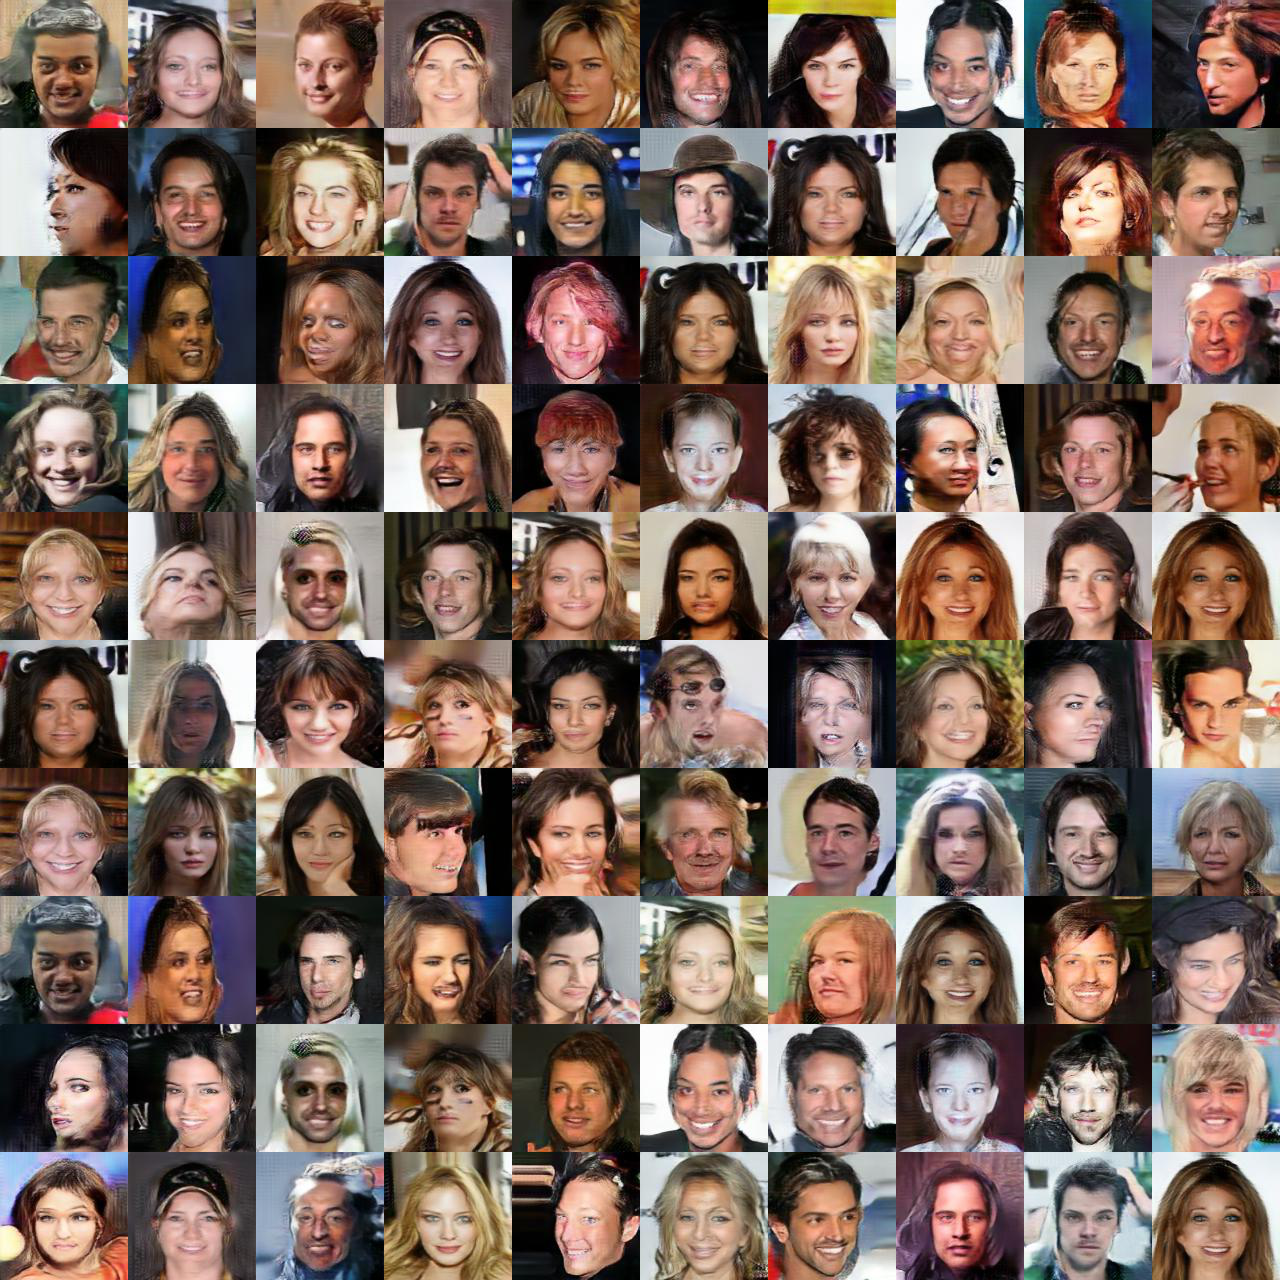

In [13]:
images = []
for i, filepath in enumerate(glob(imgdir+'*')):
    if i%110 == 0:
         images.append(Image.open(filepath))

concat_image(images,10,10)